In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler, OneHotEncoder, PowerTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
import matplotlib.ticker as mticker 
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [3]:
customer_df = pd.read_csv('customer_data.csv')
payment_df = pd.read_csv('payment_data.csv') 

In [30]:
customer_df.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


In [31]:
payment_df.head()

,id,OVD_t1,OVD_t2,OVD_t3,OVD_sum,pay_normal,prod_code,prod_limit,update_date,new_balance,highest_balance,report_date
0,58987402,0,0,0,0,1,10,16500.0,04/12/2016,0.0,NaN,NaN
1,58995151,0,0,0,0,1,5,NaN,04/12/2016,588720.0,491100.0,NaN
2,58997200,0,0,0,0,2,5,NaN,04/12/2016,840000.0,700500.0,22/04/2016
3,54988608,0,0,0,0,3,10,37400.0,03/12/2016,8425.2,7520.0,25/04/2016
4,54987763,0,0,0,0,2,10,NaN,03/12/2016,15147.6,NaN,26/04/2016


### payment_data.csv:
Lịch sử thanh toán thẻ của khách hàng.

- **id**: mã khách hàng
- **OVD_t1**: số lần quá hạn loại 1
- **OVD_t2**: số lần quá hạn loại 2
- **OVD_t3**: số lần quá hạn loại 3
- **OVD_sum**: tổng số ngày quá hạn
- **pay_normal**: số lần thanh toán bình thường
- **prod_code**: mã sản phẩm tín dụng
- **prod_limit**: hạn mức tín dụng của sản phẩm
- **update_date**: ngày cập nhật tài khoản
- **new_balance**: số dư hiện tại của sản phẩm
- **highest_balance**: số dư cao nhất trong lịch sử
- **report_date**: ngày thanh toán gần nhất

### customer_data.csv:
Dữ liệu nhân khẩu học và các thuộc tính danh mục của khách hàng đã được mã hóa.

- `fea_1`
- `fea_3`
- `fea_5`
- `fea_6`
- `fea_7`
- `fea_9`
- **label** là 1: khách hàng có rủi ro tín dụng cao
- **label** là 0: khách hàng có rủi ro tín dụng thấp

In [32]:
df_full = pd.merge(customer_df, payment_df, on='id',how="inner")

In [33]:
df_full.drop_duplicates(inplace=True)

In [34]:
## Chuyển cột ngày tháng năm sang datetime
date_columns = ['update_date', 'report_date']
for col in date_columns:
    df_full[col] = pd.to_datetime(df_full[col], format='%d/%m/%Y', errors='coerce')

## 1. Quick glance at data

In [35]:
df_full.describe().T.round()

,count,mean,min,25%,50%,75%,max,std
label,8159.0,0.168526,0.0,0.0,0.0,0.0,1.0,0.374355
id,8159.0,57824359.167913,54982353.0,54990315.0,58989082.0,58996558.0,59006239.0,1821534.605653
fea_1,8159.0,5.522368,1.0,4.0,5.0,7.0,7.0,1.387334
fea_2,7176.0,1286.214465,1116.5,1247.0,1283.0,1317.875,1481.0,52.091643
fea_3,8159.0,2.319157,1.0,1.0,3.0,3.0,3.0,0.889378
fea_4,8159.0,139056.13433,15000.0,77000.0,112000.0,151000.0,1200000.0,108422.854408
fea_5,8159.0,1.940311,1.0,2.0,2.0,2.0,2.0,0.236924
fea_6,8159.0,11.028067,3.0,8.0,11.0,15.0,16.0,2.699835
fea_7,8159.0,4.884422,-1.0,5.0,5.0,5.0,10.0,3.032391
fea_8,8159.0,100.061527,64.0,90.0,105.0,111.0,115.0,12.56185


In [36]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8159 entries, 0 to 8249
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   label            8159 non-null   int64         
 1   id               8159 non-null   int64         
 2   fea_1            8159 non-null   int64         
 3   fea_2            7176 non-null   float64       
 4   fea_3            8159 non-null   int64         
 5   fea_4            8159 non-null   float64       
 6   fea_5            8159 non-null   int64         
 7   fea_6            8159 non-null   int64         
 8   fea_7            8159 non-null   int64         
 9   fea_8            8159 non-null   int64         
 10  fea_9            8159 non-null   int64         
 11  fea_10           8159 non-null   int64         
 12  fea_11           8159 non-null   float64       
 13  OVD_t1           8159 non-null   int64         
 14  OVD_t2           8159 non-null   int64       

In [37]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mz_table = mz_table[mz_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        return mz_table
missing_values_table(df_full)

,Missing Values,% of Total Values
prod_limit,6040,74.0
report_date,1091,13.4
fea_2,983,12.0
highest_balance,396,4.9
update_date,21,0.3


## 2. Phân tích dữ liệu cơ bản + xử lý dữ liệu

### Chia tập dữ liệu

In [38]:
train_df, test_df = train_test_split(df_full, test_size=0.2, random_state=42, stratify=df_full['label'])

In [39]:
missing_values_table(train_df)

,Missing Values,% of Total Values
prod_limit,4835,74.1
report_date,867,13.3
fea_2,798,12.2
highest_balance,320,4.9
update_date,16,0.2


### Xem phân phối tổng quát

Các cột numeric


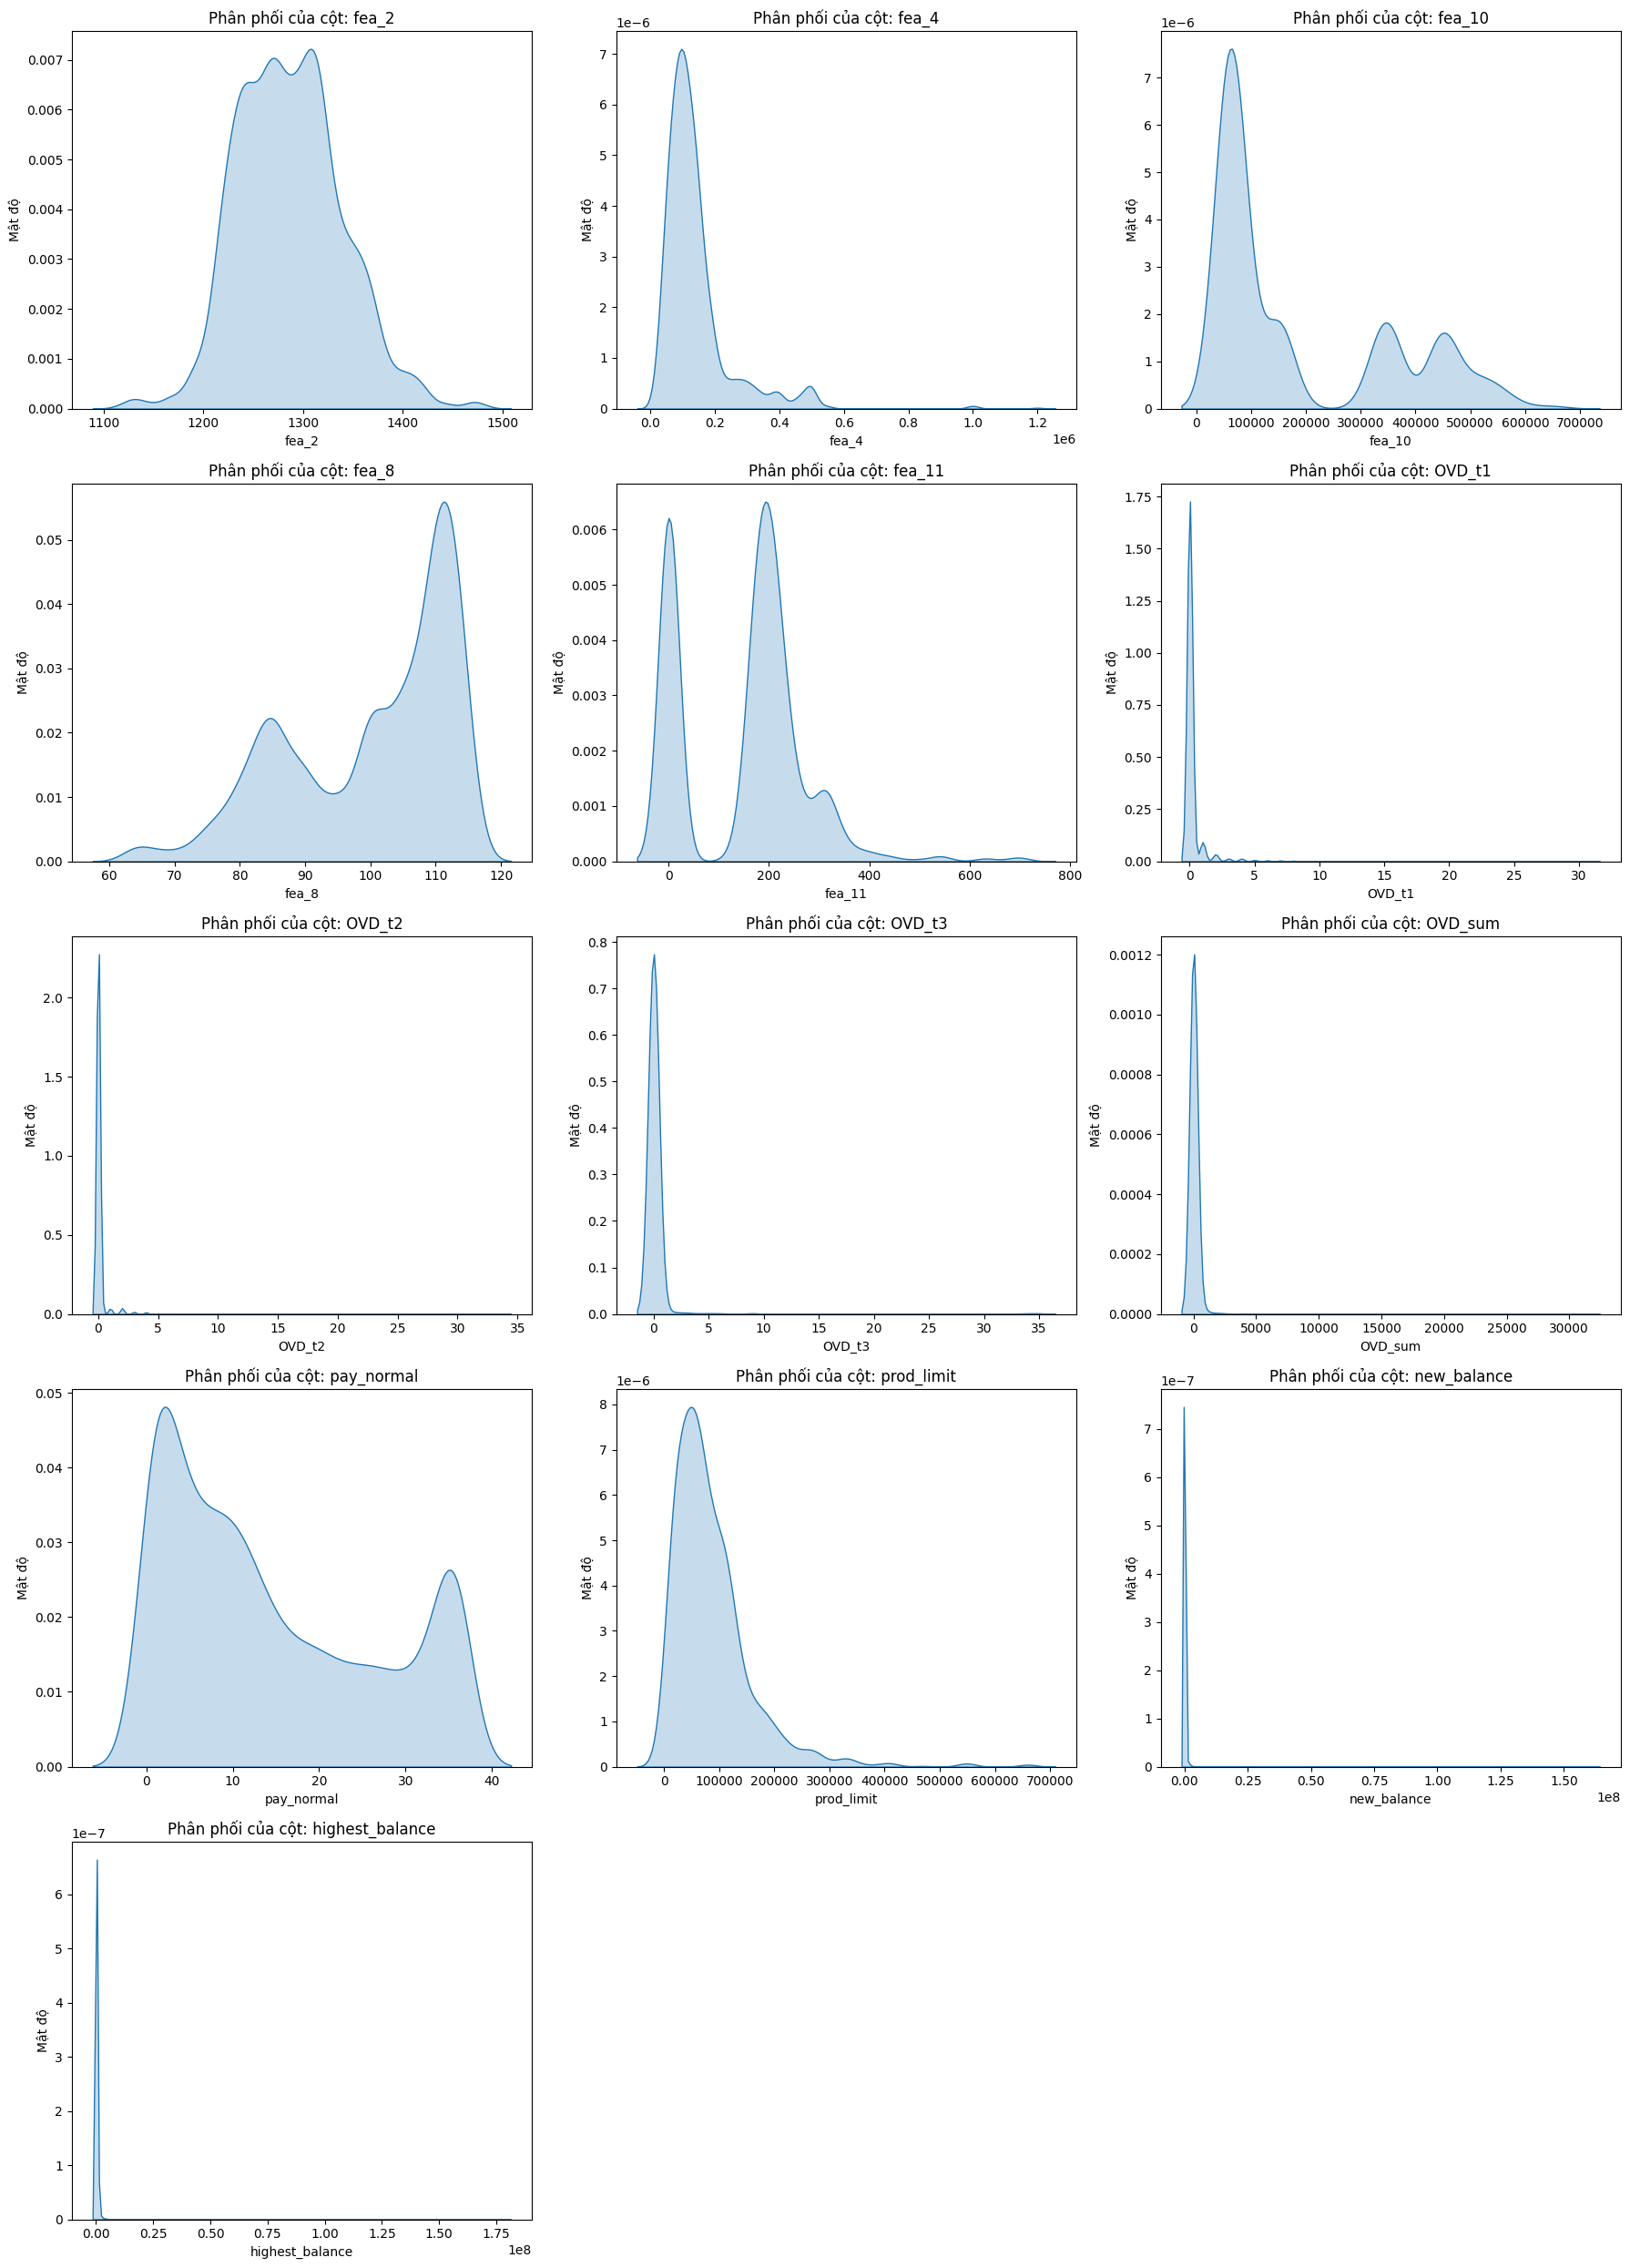

Các cột category


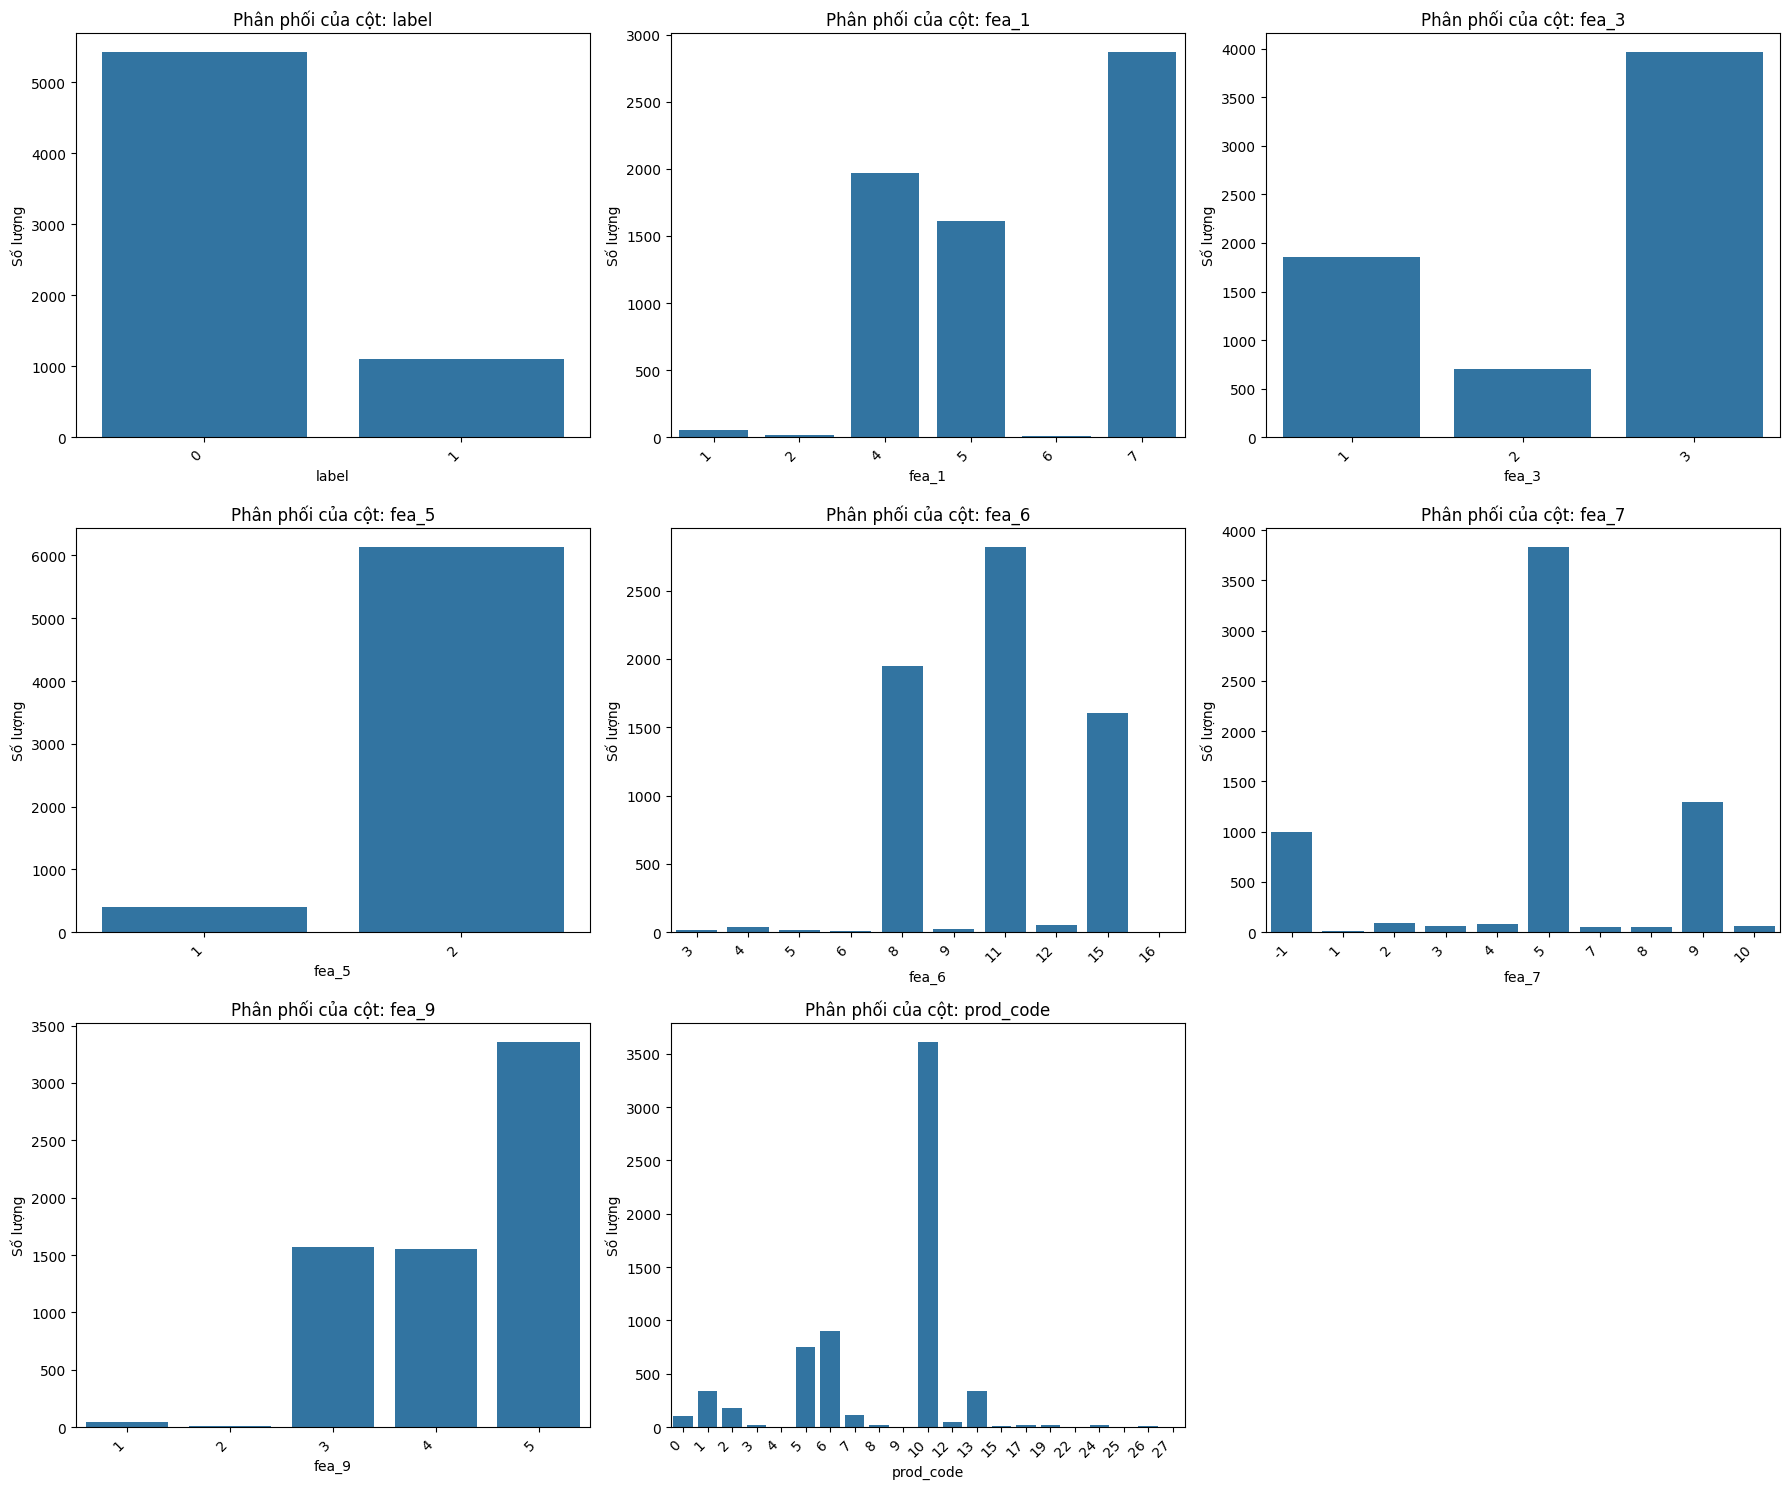

In [40]:
# Xác định lại các cột số và cột phân loại
numerical_cols = [
    'fea_2', 'fea_4', 'fea_10','fea_8','fea_11',
    'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal',
    'prod_limit', 'new_balance', 'highest_balance'
]
categorical_cols = [
    'label','fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7',  'fea_9',
    'prod_code'
]

# Vẽ KDE plot cho các cột số (3 đồ thị trên 1 hàng)
print("Các cột numeric")
n_numerical = len(numerical_cols)
n_rows_numerical = math.ceil(n_numerical / 3)
fig_numerical, axes_numerical = plt.subplots(n_rows_numerical, 3, figsize=(18, n_rows_numerical * 5))
axes_numerical = axes_numerical.flatten()

for i, col in enumerate(numerical_cols):
    sns.kdeplot(data=train_df, x=col, fill=True, ax=axes_numerical[i])
    axes_numerical[i].set_title(f'Phân phối của cột: {col}')
    axes_numerical[i].set_xlabel(col)
    axes_numerical[i].set_ylabel('Mật độ')

# Ẩn các subplot không sử dụng
for j in range(i + 1, len(axes_numerical)):
    fig_numerical.delaxes(axes_numerical[j])

plt.tight_layout()
plt.show()

# Vẽ biểu đồ cột cho các cột phân loại (3 đồ thị trên 1 hàng)
print("Các cột category")
n_categorical = len(categorical_cols)
n_rows_categorical = math.ceil(n_categorical / 3)
fig_categorical, axes_categorical = plt.subplots(n_rows_categorical, 3, figsize=(18, n_rows_categorical * 5))
axes_categorical = axes_categorical.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=train_df, x=col, ax=axes_categorical[i])
    axes_categorical[i].set_title(f'Phân phối của cột: {col}')
    axes_categorical[i].set_xlabel(col)
    axes_categorical[i].set_ylabel('Số lượng')

    # Sửa lỗi ở đây: Sử dụng set_xticklabels để xoay và căn chỉnh nhãn
    axes_categorical[i].set_xticklabels(axes_categorical[i].get_xticklabels(), rotation=45, ha='right')


# Ẩn các subplot không sử dụng
for j in range(i + 1, len(axes_categorical)):
    fig_categorical.delaxes(axes_categorical[j])

plt.tight_layout()
plt.show()


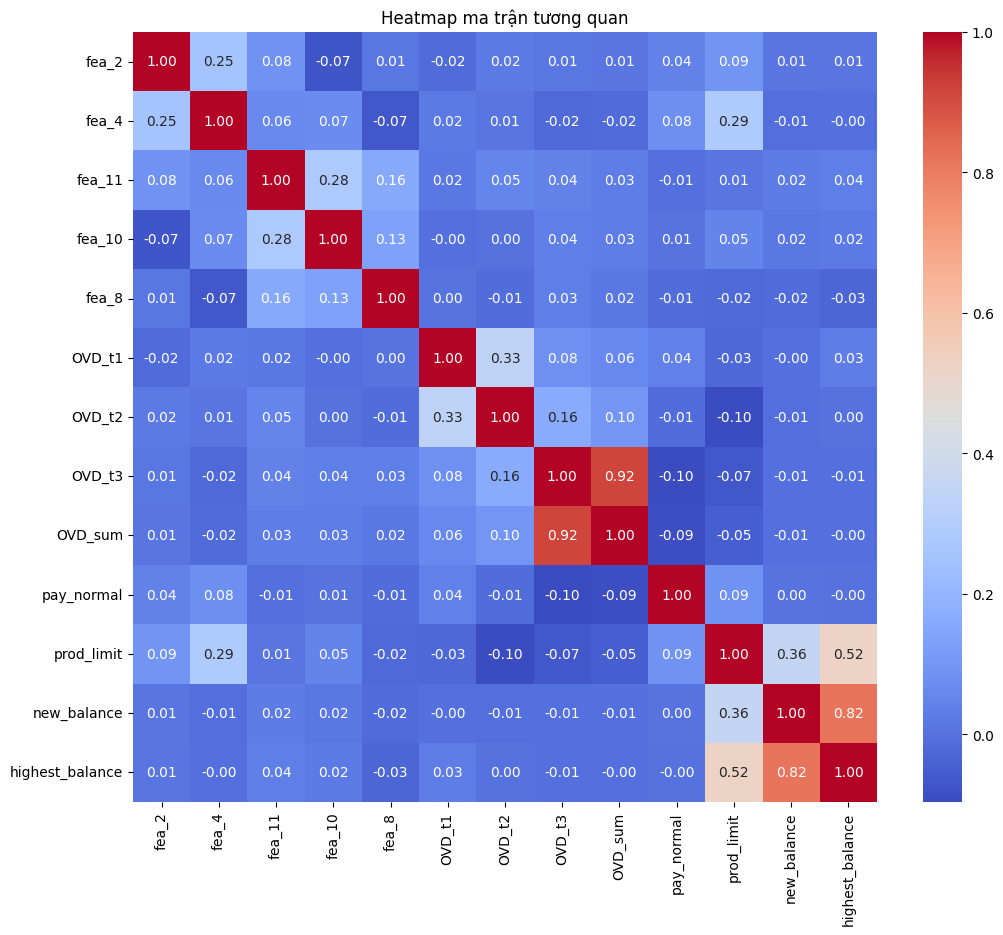

In [41]:
# Xác định các cột số (bao gồm fea_8 và fea_10)
numerical_cols = [
    'fea_2', 'fea_4', 'fea_11', 'fea_10', 'fea_8',
    'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal',
    'prod_limit', 'new_balance', 'highest_balance'
]

# Chọn chỉ các cột số từ DataFrame
df_numerical = train_df[numerical_cols]

# Tính ma trận tương quan
correlation_matrix = df_numerical.corr()

# Vẽ heatmap của ma trận tương quan
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap ma trận tương quan')
plt.show()


In [42]:
# Xem xem có id nào bị gán nhãn là cả 0 và 1 không
train_df.groupby('id')["label"].nunique().pipe(lambda x: x[x > 1])

Series([], Name: label, dtype: int64)

### Tìm hiểu những cột NULL + đề xuất phương án xử lý

### ***C. Tìm hiểu vấn đề về cột prod_limit***

Tạo biến chỉ báo prod_limit_is_missing 

In [43]:
#Check xem nhóm rủi ro cao có tỷ lệ thiếu "prod_limit" cao hơn không
train_df['prod_limit_is_missing'] = train_df['prod_limit'].isnull().astype(int)
test_df["prod_limit_is_missing"] = test_df["prod_limit"].isnull().astype(int)

#### 1. Phân tích null của cột này

a. Giả thuyết: Null có nghĩa là "sản phẩm không có hạn mức tín dụng"


Tỷ lệ prod_limit bị thiếu theo từng prod_code (sắp xếp từ cao đến thấp):
prod_code
0     100.000000
1     100.000000
2     100.000000
3     100.000000
4     100.000000
5     100.000000
6     100.000000
7     100.000000
8     100.000000
9     100.000000
12    100.000000
13    100.000000
15    100.000000
26    100.000000
17    100.000000
19    100.000000
24    100.000000
27    100.000000
25    100.000000
22     66.666667
10     53.144915
Name: prod_limit, dtype: float64


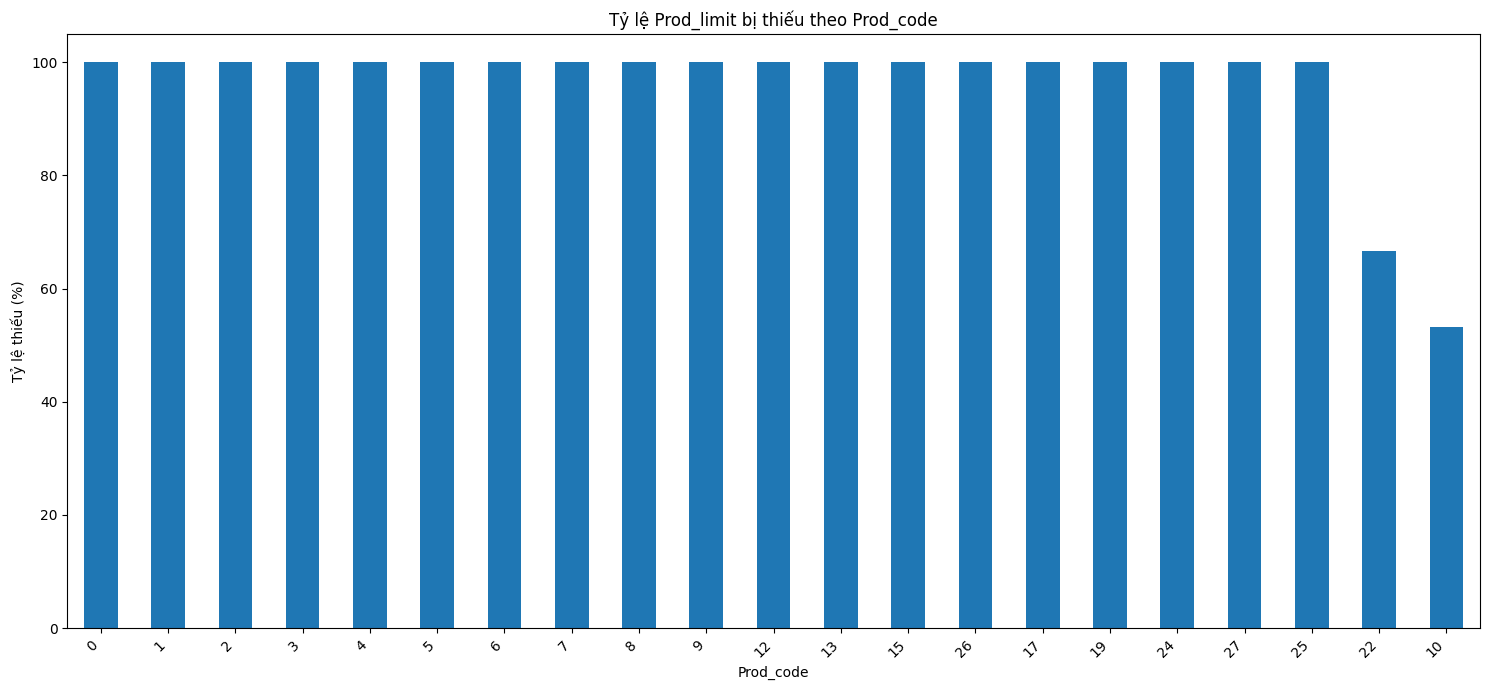

In [44]:
# Tính tỷ lệ prod_limit bị thiếu cho mỗi prod_code và sắp xếp
prod_code_missing_ratio = train_df.groupby('prod_code')['prod_limit'].apply(lambda x: x.isnull().mean()*100).sort_values(ascending=False)

print("\nTỷ lệ prod_limit bị thiếu theo từng prod_code (sắp xếp từ cao đến thấp):")
print(prod_code_missing_ratio.head(21)) # In ra 20 dòng đầu để xem

# Vẽ biểu đồ cột
plt.figure(figsize=(15, 7)) # Điều chỉnh kích thước figure
prod_code_missing_ratio.plot(kind='bar')
plt.title('Tỷ lệ Prod_limit bị thiếu theo Prod_code')
plt.xlabel('Prod_code')
plt.ylabel('Tỷ lệ thiếu (%)')
plt.xticks(rotation=45, ha='right') # Xoay nhãn trục x để dễ đọc
plt.tight_layout() # Điều chỉnh layout
plt.show()


-> Tôi thấy một vài sản phẩm (ngoại trừ 22,10) có tỷ lệ null của cột prod_limit là 100%. Tuy nhiên các cột prod_code = 22, 10 thì lại có tỷ lệ không phải 100%. Chứng tỏ 2 cột này có tồn tại null -> Chứng tỏ null không đại diện cho "sản phẩm không có khái niệm giới hạn định mức" (bởi 22,10 vẫn bị giới hạn)

Tôi lại nghĩ đến giả thiết khác xảy ra là: với những giá trị null, nó ám chỉ đến việc sản phẩm này (tương ứng với người dùng nào đó sử dụng) chưa bị áp hạn mức do chưa vi phạm điều gì đó ?

b. Giả thuyết 2: Ban đầu, sản phẩm người dùng không bị giới hạn tín dụng (tức prod_limit = NULL). Nhưng sau đó, do vi phạm chính sách nào đó (hoặc có thể vì vấn đề nào đó khác) dẫn đến việc người đó bị prod_limit khác null (tức là lúc này người này bị giới hạn tín dụng)

Việc vi phạm chính sách dẫn đến prod_limit bị khác null (tức là lúc đó người dùng bị áp đặt hạn mức) có thể liên quan đến biến OVD_t1, OVD_t2, OVD_t3, OVD_sum

In [45]:
print("\nMô tả các biến OVD và pay_normal khi prod_limit BỊ THIẾU:")
print(train_df[train_df['prod_limit'].isnull()][['OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal']].describe())

print("\nMô tả các biến OVD và pay_normal khi prod_limit KHÔNG BỊ THIẾU:")
print(train_df[train_df['prod_limit'].notnull()][['OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal']].describe())


Mô tả các biến OVD và pay_normal khi prod_limit BỊ THIẾU:
            OVD_t1       OVD_t2       OVD_t3       OVD_sum   pay_normal
count  4835.000000  4835.000000  4835.000000   4835.000000  4835.000000
mean      0.242399     0.145398     0.447777    233.206618    13.714581
std       1.296211     1.000495     3.204309   2035.614896    11.683933
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%       0.000000     0.000000     0.000000      0.000000     4.000000
50%       0.000000     0.000000     0.000000      0.000000    10.000000
75%       0.000000     0.000000     0.000000      0.000000    22.000000
max      31.000000    34.000000    35.000000  31500.000000    36.000000

Mô tả các biến OVD và pay_normal khi prod_limit KHÔNG BỊ THIẾU:
            OVD_t1       OVD_t2       OVD_t3       OVD_sum   pay_normal
count  1692.000000  1692.000000  1692.000000   1692.000000  1692.000000
mean      0.244090     0.079196     0.136525     71.304965    16.867021
std       0.

##### -> Ở đây ta thấy được rằng: 
+ các giá trị mean tương ứng của các cột OVD khi prod_limit thiếu đều lớn hơn so với prod_limit không thiếu
+ mặt khác, pay_normal (chi trả bình thường) khi prod_limit thiếu thì mean lại có xu hướng ít hơn so với TH không bị thiếu (có thể là khi bị giới hạn tín dụng rồi, họ mới chi trả bthg. Còn đâu lúc ch bị, họ hay cheat)
+ Ở phần max cũng đa phần đều lớn hơn hoặc bằng  
##### -> Các điều trên đang củng cố giả thuyết của chúng ta

##### Ta tập trung vào các prod_code 22 và 10 do chúng có tồn tại những giá trị vừa null vừa 0 null ở cột prod_limit

In [46]:
df_10_and_22 = train_df[(train_df['prod_code'] == 10) | (train_df['prod_code'] == 22)]

In [47]:

# Nhóm theo id và prod_code, sau đó đếm số lượng bản ghi (không null) cho mỗi nhóm trong cột update_date
update_date_counts = df_10_and_22.groupby(["id","prod_code","update_date"])["prod_limit_is_missing"].value_counts().head(20)

print("Số lượng bản ghi theo ID và Prod_code và update_date (cho prod_limit_is_missing):")
print(update_date_counts)

Số lượng bản ghi theo ID và Prod_code và update_date (cho prod_limit_is_missing):
id        prod_code  update_date  prod_limit_is_missing
54982353  10         1994-12-18   1                        1
                     1997-04-21   0                        1
                     2003-01-05   0                        1
                     2003-09-17   1                        1
                     2003-10-17   1                        1
                     2005-04-22   1                        1
                     2005-09-30   1                        1
                     2006-01-08   1                        1
                     2007-03-12   1                        2
                                  0                        1
                     2011-07-16   1                        1
                     2013-09-03   0                        1
                     2014-08-27   0                        1
54982356  10         2006-03-30   1                        1
54982387

-> Củng cố thêm giả thuyết của ta rằng: có khoảng thời gian, người dùng bị giối hạn, sau được gỡ, sau lại bị giới hạn

#### Vậy giá trị null ở đây có thể là các TH khả nghi như:
Khách hàng không đủ điều kiện để được cấp hạn mức tín dụng rõ ràng (có thể liên quan đến rủi ro của họ).Trong một số trường hợp, hạn mức có thể đã từng được áp dụng rồi lại được gỡ bỏ, cho thấy một quy trình quản lý hạn mức động

#### 2. kiểm tra xem cột prod_limit_is_missing mới này có ảnh hưởng đến target không

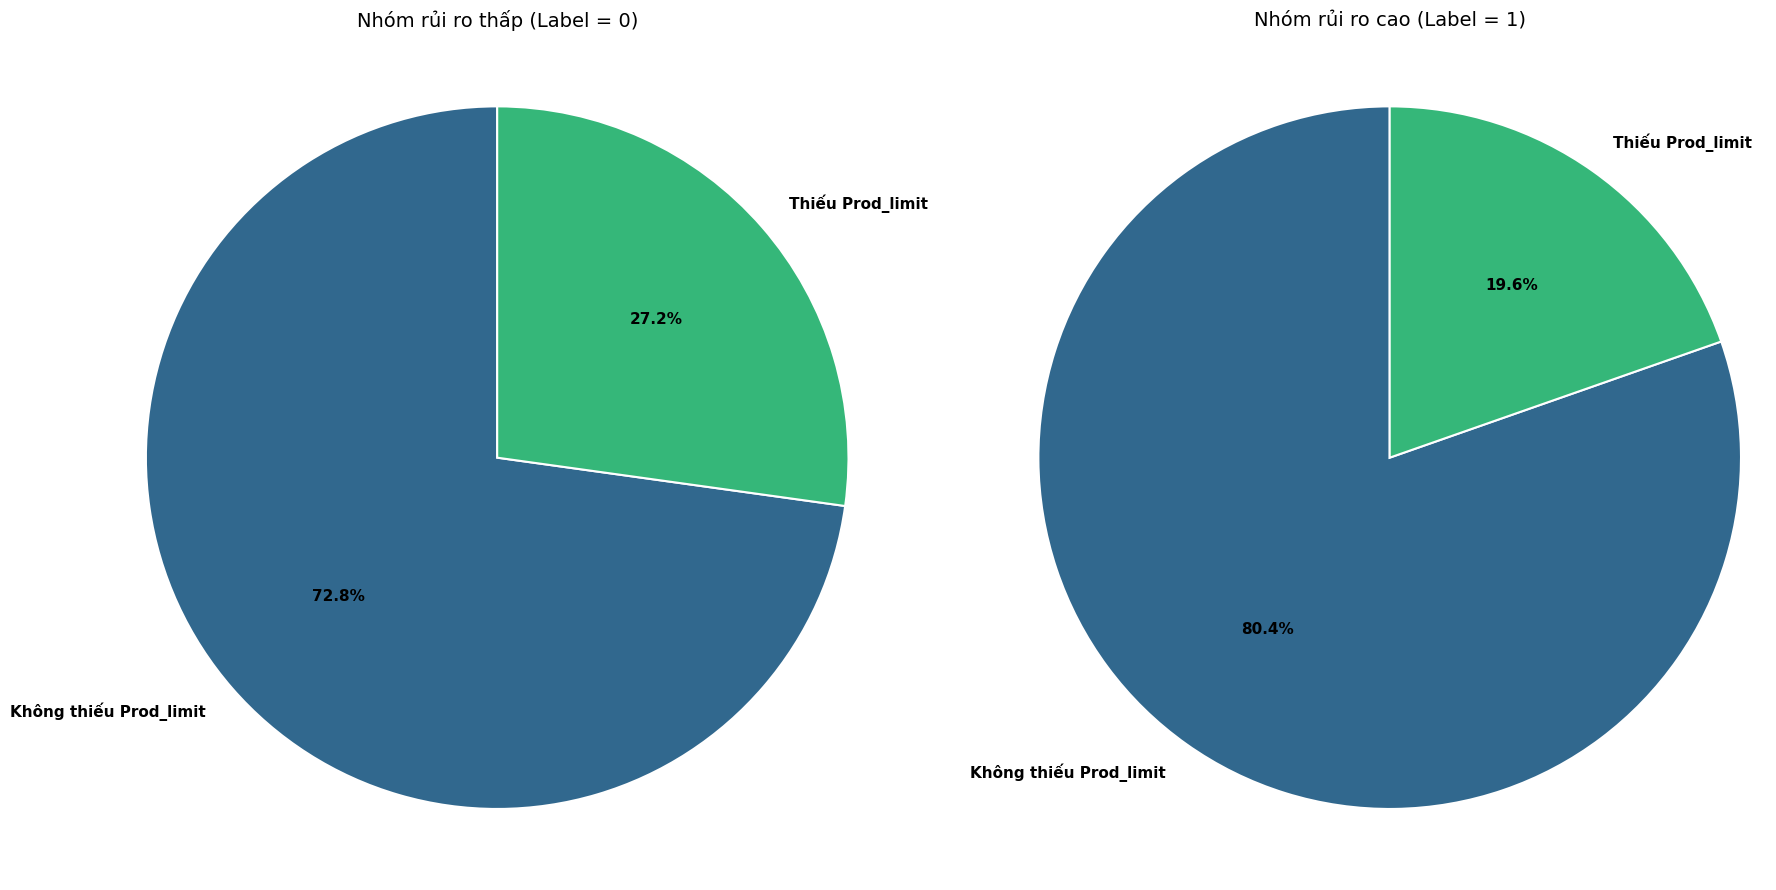

In [48]:
# Giả sử các thư viện cần thiết (pandas, matplotlib.pyplot, seaborn) đã được import và df_full đã được tạo

# Lọc ra nhóm khách hàng có rủi ro thấp (label == 0)
low_risk_df = train_df[train_df['label'] == 0]

# Lọc ra nhóm khách hàng có rủi ro cao (label == 1)
high_risk_df = train_df[train_df['label'] == 1]

# Đếm số lượng cho từng trường hợp thiếu/không thiếu prod_limit trong nhóm rủi ro thấp
missing_limit_counts_low_risk = low_risk_df['prod_limit'].isnull().value_counts()

# Đếm số lượng cho từng trường hợp thiếu/không thiếu prod_limit trong nhóm rủi ro cao
missing_limit_counts_high_risk = high_risk_df['prod_limit'].isnull().value_counts()


# Tạo figure và các subplots (1 hàng, 2 cột)
fig, axes = plt.subplots(1, 2, figsize=(18, 9)) # Giữ kích thước figure

# Màu sắc tùy chỉnh (ví dụ: sử dụng bảng màu 'viridis' từ seaborn)
colors = sns.color_palette('viridis', 2) # Lấy 2 màu từ bảng màu viridis

# Nhãn cho biểu đồ tròn
pie_labels = ['Không thiếu Prod_limit', 'Thiếu Prod_limit']

# Vẽ biểu đồ tròn cho nhóm rủi ro thấp trên subplot đầu tiên
axes[0].pie(missing_limit_counts_low_risk,
            labels=pie_labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
            textprops={'fontsize': 11, 'color': 'black', 'weight': 'bold'}) # Điều chỉnh màu và độ đậm của chữ

axes[0].set_title('Nhóm rủi ro thấp (Label = 0)', fontsize=14)
axes[0].axis('equal') # Đảm bảo biểu đồ tròn là hình tròn

# Vẽ biểu đồ tròn cho nhóm rủi ro cao trên subplot thứ hai
axes[1].pie(missing_limit_counts_high_risk,
            labels=pie_labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
            textprops={'fontsize': 11, 'color': 'black', 'weight': 'bold'}) # Điều chỉnh màu và độ đậm của chữ

axes[1].set_title('Nhóm rủi ro cao (Label = 1)', fontsize=14)
axes[1].axis('equal') # Đảm bảo biểu đồ tròn là hình tròn

plt.tight_layout() # Điều chỉnh layout
plt.show()

Như tôi dự đoán ở trên nãy, do tôi vẫn nghĩ có thể khả năng cao null ở đây mang nghĩa không bị giới hạn tín dụng, còn khác null mang nghĩa bị giới hạn tín dụng (có thể do người dùng vi phạm chính sách thẻ dẫn đến rủi ro hay là tự đặt giới hạn cho thẻ khi nhận thấy rủi ro,...) thế nên ở đây prod_limit bị thiếu ở nhóm rủi ro thấp có xu hướng cao hơn prod_limit bị thiếu ở nhóm rủi ro cao. Tuy nhiên, như tôi nói, đây vẫn chỉ là giả định của tôi chứ thực tế ra sao chúng ta cần hỏi người cung cấp dữ liệu

2 biểu đồ tròn trên là khi ta so sánh trong TH: (id,lanbel,prod_code) bị lặp lại, tức là khi thẻ của 1 người nào đó bị xuất hiện prod_limit null nhiều lần (và cả không null cũng xuất hiện nhiều lần với thẻ đó) và trong tất cả TH thì người đó đều bị coi là label 1  
VD:
Khi biểu điễn bảng:   
id - prod_code - update_date - prod_limit - label  
1999 - 10 - 3/2 - null - 1      
1999 - 10 - 4/5 - null - 1    
1999 - 10 - 4/5 - không null - 1     
1999 - 10 - 5/5 - null - 1  
1999 - 10 - 6/5 - không null - 1  
-> Ta thấy vấn đề ở đây là một người bị xét là null quá nhiều lần, trong khi label người đó thì đã bị gán là 1. Vậy nên việc so sánh như trên là có vẻ chưa trung thực lắm (vì chỉ cần người đó bị gán label 1 cái là tất cả prod_limit dù null hay không null của người đó đều có label = 1)

Đề xuất xử lý: tạo 1 dataframe khác loại bỏ trùng ở các cột id, prod_limit_is_missing với mục tiêu: tránh để prod_limit xuất hiện nhiều lần trên cùng một người 

In [49]:
df_remove_dup_id_prod = train_df.drop_duplicates(subset=["id", "prod_limit_is_missing"])

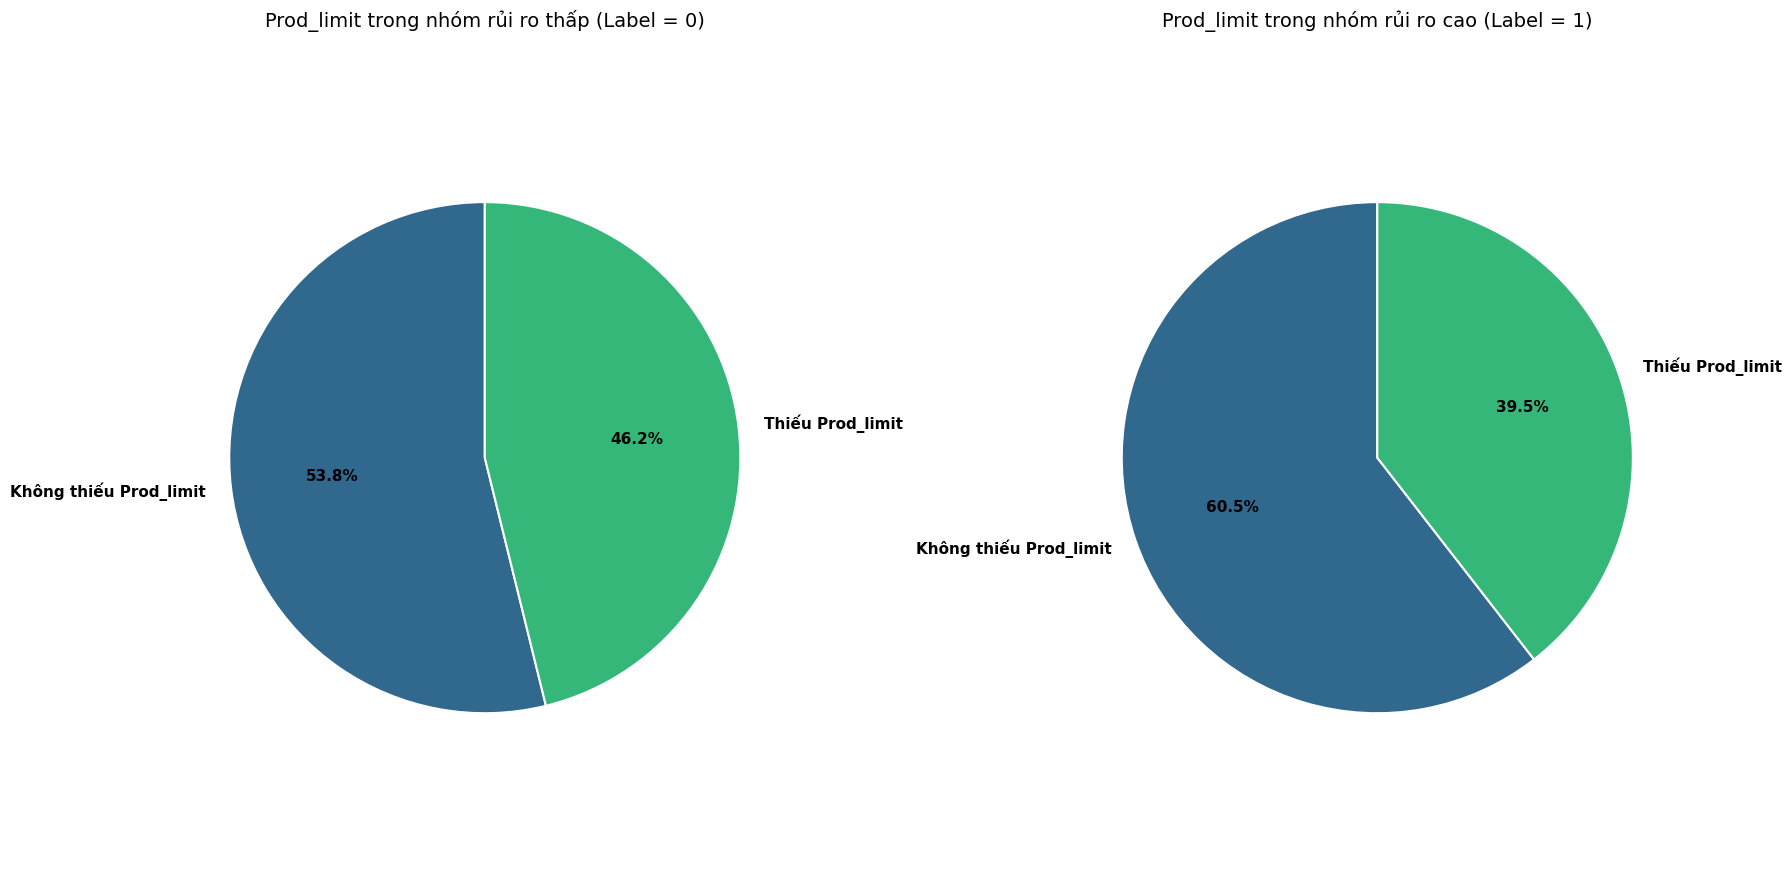

In [50]:
# Giả sử các thư viện cần thiết (pandas, matplotlib.pyplot, seaborn) đã được import và df_full đã được tạo

# Lọc ra nhóm khách hàng có rủi ro thấp (label == 0)
low_risk_df = df_remove_dup_id_prod[df_remove_dup_id_prod['label'] == 0]

# Lọc ra nhóm khách hàng có rủi ro cao (label == 1)
high_risk_df = df_remove_dup_id_prod[df_remove_dup_id_prod['label'] == 1]

# Đếm số lượng cho từng trường hợp thiếu/không thiếu prod_limit trong nhóm rủi ro thấp
missing_limit_counts_low_risk = low_risk_df['prod_limit'].isnull().value_counts()

# Đếm số lượng cho từng trường hợp thiếu/không thiếu prod_limit trong nhóm rủi ro cao
missing_limit_counts_high_risk = high_risk_df['prod_limit'].isnull().value_counts()


# Tạo figure và các subplots (1 hàng, 2 cột)
fig, axes = plt.subplots(1, 2, figsize=(18, 9)) # Giữ kích thước figure

# Màu sắc tùy chỉnh (ví dụ: sử dụng bảng màu 'viridis' từ seaborn)
colors = sns.color_palette('viridis', 2) # Lấy 2 màu từ bảng màu viridis

# Nhãn cho biểu đồ tròn
pie_labels = ['Không thiếu Prod_limit', 'Thiếu Prod_limit']

# Vẽ biểu đồ tròn cho nhóm rủi ro thấp trên subplot đầu tiên
axes[0].pie(missing_limit_counts_low_risk,
            labels=pie_labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
            textprops={'fontsize': 11, 'color': 'black', 'weight': 'bold'}) # Điều chỉnh màu và độ đậm của chữ

axes[0].set_title('Prod_limit trong nhóm rủi ro thấp (Label = 0)', fontsize=14)
axes[0].axis('equal') # Đảm bảo biểu đồ tròn là hình tròn

# Vẽ biểu đồ tròn cho nhóm rủi ro cao trên subplot thứ hai
axes[1].pie(missing_limit_counts_high_risk,
            labels=pie_labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
            textprops={'fontsize': 11, 'color': 'black', 'weight': 'bold'}) # Điều chỉnh màu và độ đậm của chữ

axes[1].set_title('Prod_limit trong nhóm rủi ro cao (Label = 1)', fontsize=14)
axes[1].axis('equal') # Đảm bảo biểu đồ tròn là hình tròn

plt.tight_layout() # Điều chỉnh layout
plt.show()

Ở đây khách quan hơn, tuy vậy chúng ta vẫn thấy prod_limit thiếu ở label = 0 vãn lớn hơn label = 1. Và ở đây tôi nhận định rằng biến prod_limit_is_missing là có ý nghĩa trong việc dự đoán label

Phương án xử lý: 
+ Giữ prod_limit_is_missing
+ Thay các giá trị null của prod_limit bằng giá trị 0 với ý nghĩa: "khách hàng/sản phẩm đó không có hạn mức tín dụng" hoặc "hạn mức không áp dụng"

### ***A. Phân tích và xử lý cột report_date***

#### 1. Phân tích sơ bộ

In [51]:
# Khoảng thời gian bao phủ:
print(f"Ngày report_date sớm nhất: {train_df['report_date'].min()}")
print(f"Ngày report_date gần nhất: {train_df['report_date'].max()}")

Ngày report_date sớm nhất: 1996-02-24 00:00:00
Ngày report_date gần nhất: 2016-12-06 00:00:00


#### Phán đoán nguyên nhân report_date bị thiếu:

1. Giả thuyết 1: Do chưa bao giờ giao dịch ?

In [52]:
print(train_df[train_df['report_date'].isnull()][['OVD_t1', 'OVD_sum', 'pay_normal']].describe())

           OVD_t1       OVD_sum  pay_normal
count  867.000000    867.000000  867.000000
mean     0.220300     59.200692    5.683968
std      1.186395    702.914501    8.363799
min      0.000000      0.000000    0.000000
25%      0.000000      0.000000    1.000000
50%      0.000000      0.000000    2.000000
75%      0.000000      0.000000    6.000000
max     16.000000  18666.000000   36.000000


-> Sai vì nếu thế OVD_sum ít nhất phải bằng không

2. Do người thu thập dữ liệu không xác định được thời điểm giao dịch gần nhất ?

In [53]:
# Tính tỷ lệ phần trăm giá trị NULL trong cột report_date, nhóm theo id
report_date_null_percentage_by_id = train_df.groupby('id')['report_date'].apply(lambda x: x.isnull().mean() * 100)

# Sắp xếp kết quả từ lớn nhất đến bé nhất
sorted_report_date_null_percentage_by_id = report_date_null_percentage_by_id.sort_values(ascending=False)

print("Tỷ lệ phần trăm Report Date bị thiếu \ntheo từng ID (sắp xếp từ cao đến thấp)\nlấy ra khoảng 20 người:")
print(sorted_report_date_null_percentage_by_id.head(20))


Tỷ lệ phần trăm Report Date bị thiếu 
theo từng ID (sắp xếp từ cao đến thấp)
lấy ra khoảng 20 người:
id
54983809    100.000000
58990258    100.000000
54990339    100.000000
54988633    100.000000
54985624    100.000000
58994549    100.000000
58999709     85.714286
58992481     75.000000
58987924     70.000000
54983721     66.666667
54983279     66.666667
59002775     66.666667
58998925     66.666667
58994429     66.666667
54987936     66.666667
59002314     63.636364
54982356     60.000000
58984708     60.000000
58982376     57.142857
59005841     57.142857
Name: report_date, dtype: float64


-> Từ đây ta thấy được là có vài người thì tỷ lệ null của cột đó là 100%, còn một vài người thì 75%, 66%,... Vậy nguyên nhân có thể đúng là do người thu thập có thể không xác định được những giao dịch gần đây hoặc chưa cập nhật những giao dịch gần đây vào trong dữ liệu nên nó mới bị null như vậy

#### Kiểm tra kỹ hơn

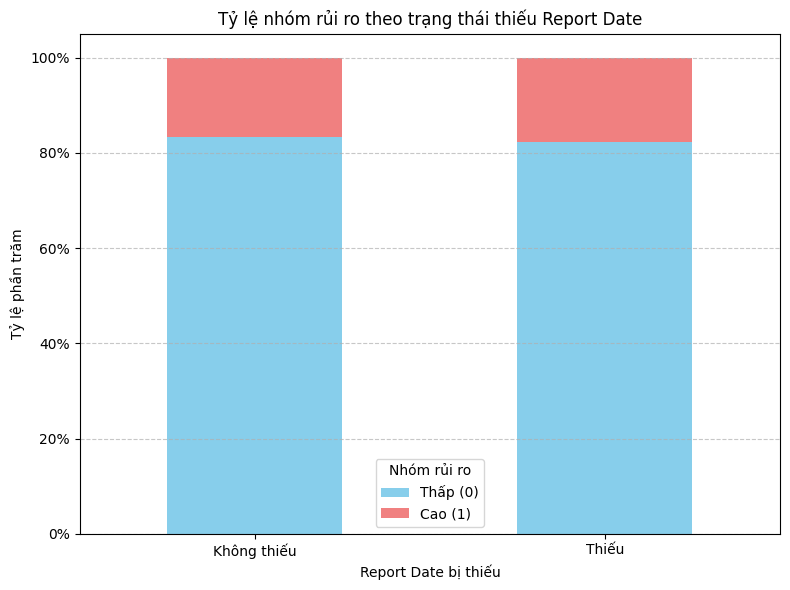

In [54]:
# Tính bảng crosstab với tỷ lệ phần trăm theo hàng
crosstab_result = pd.crosstab(train_df['report_date'].isnull(), train_df['label'], normalize='index')

# Vẽ biểu đồ cột chồng
ax = crosstab_result.plot(kind='bar', stacked=True, figsize=(8, 6), color=['skyblue', 'lightcoral'])

plt.title('Tỷ lệ nhóm rủi ro theo trạng thái thiếu Report Date')
plt.xlabel('Report Date bị thiếu')
plt.ylabel('Tỷ lệ phần trăm')
plt.xticks(ticks=[0, 1], labels=['Không thiếu', 'Thiếu'], rotation=0) # Đặt nhãn trục x rõ ràng
plt.legend(title='Nhóm rủi ro', labels=['Thấp (0)', 'Cao (1)'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0%', '20%', '40%', '60%', '80%', '100%']) # Định dạng trục y thành phần trăm
plt.grid(axis='y', linestyle='--', alpha=0.7) # Thêm lưới ngang
plt.tight_layout() # Điều chỉnh layout
plt.show()


-> Không có sự khác biệt giữa thiếu/không thiếu report_date đối với label, cho ta thấy được rằng việc thiếu có thể là ngẫu nhiên, không liên quan đến hành vi của khách hàng

Tuy nhiên, vì cột này thiếu khá nhiều (13.2%) nên việc tạo biến chỉ báo theo tôi vẫn là nên để mô hình có thể biết được đâu là giá trị ta đã thay null, đâu là giá trị ta chưa thay null

In [55]:
train_df['report_date_is_missing'] = train_df['report_date'].isnull().astype(int)
test_df['report_date_is_missing'] = test_df['report_date'].isnull().astype(int)

#### Phương án xử lý NULL: tách cột này ra thành ngày/ tháng / năm và thay thế null bằng cách dùng KNN Imputer (sau khi chia tập dữ liệu)

In [56]:
# Tách cột report_date thành ngày, tháng, năm
train_df['report_year'] = train_df['report_date'].dt.year
train_df['report_month'] = train_df['report_date'].dt.month
train_df['report_day'] = train_df['report_date'].dt.day
train_df.drop("report_date",axis=1,inplace=True)
test_df['report_year'] = test_df['report_date'].dt.year
test_df['report_month'] = test_df['report_date'].dt.month
test_df['report_day'] = test_df['report_date'].dt.day
test_df.drop("report_date",axis=1,inplace=True)

### ***B. Tìm hiểu về cột update_date***

Cột này tuy trước đó người thực hiện đã phân tích, nhưng vẫn chưa hiểu rõ ý nghĩa thực sự của cột nên đã xóa đi phần phân tích đó. Vậy nên, người thực hiện xin phép không phân tích

Ta tập trung xem mấy giá trị null

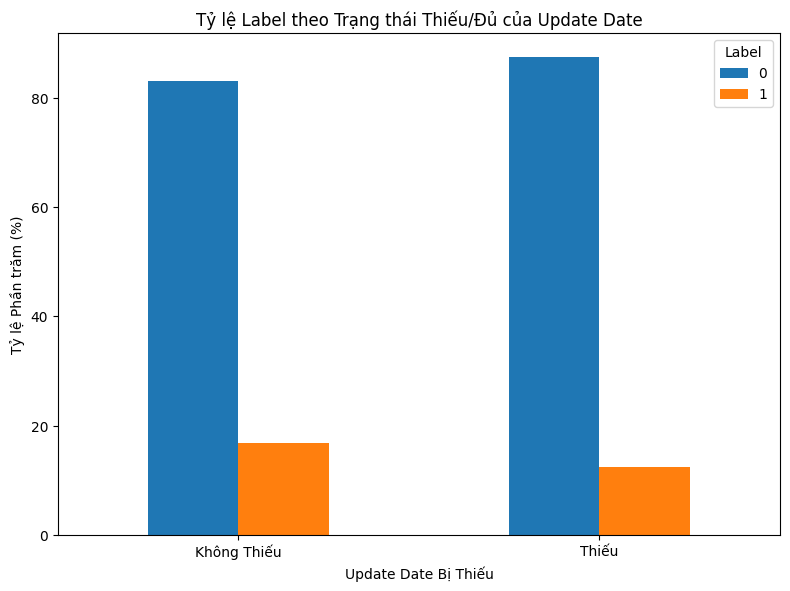

In [57]:

# Tạo biến chỉ báo
train_df['update_date_is_missing'] = train_df['update_date'].isnull().astype(int)
# Tính bảng chéo tỷ lệ phần trăm theo hàng (Risk Rate)
cross_tab_row_pct = pd.crosstab(train_df['update_date_is_missing'], train_df['label'], normalize='index') * 100

# Vẽ biểu đồ cột (không chồng)
ax1 = cross_tab_row_pct.plot(kind='bar', stacked=False, figsize=(8, 6))
plt.title('Tỷ lệ Label theo Trạng thái Thiếu/Đủ của Update Date')
plt.xlabel('Update Date Bị Thiếu') # Cập nhật nhãn trục x
plt.ylabel('Tỷ lệ Phần trăm (%)')
plt.xticks(rotation=0)
plt.legend(title='Label')
plt.tight_layout()
# Đổi nhãn trục x
ax1.set_xticklabels(['Không Thiếu', 'Thiếu'])
plt.show()

In [58]:
train_df.drop(["update_date_is_missing"],axis=1,inplace=True)

-> Tiếp tục chia cột này ra thành 3 cột day/month/year, thay null bằng KNN

In [59]:
# Giả sử cột 'update_date' đã là datetime

# Tách cột update_date thành ngày, tháng, năm
train_df['update_year'] = train_df['update_date'].dt.year
train_df['update_month'] = train_df['update_date'].dt.month
train_df['update_day'] = train_df['update_date'].dt.day

# Xóa cột update_date gốc
train_df.drop("update_date", axis=1, inplace=True)

# Tách cột update_date thành ngày, tháng, năm
test_df['update_year'] = test_df['update_date'].dt.year
test_df['update_month'] = test_df['update_date'].dt.month
test_df['update_day'] = test_df['update_date'].dt.day

# Xóa cột update_date gốc
test_df.drop("update_date", axis=1, inplace=True)

### ***D. Xử lý null của cột highest_balance*** 

-> Thay thế null của cột này bằng trung bình highest_balance tương ứng của mỗi người

In [60]:
# Lấy ra các highest_balance mỗi người
df_subset_highest_balance = train_df[["id","highest_balance"]].drop_duplicates()
highest_balance_mean_person = df_subset_highest_balance.groupby('id')['highest_balance'].mean()

In [61]:
highest_balance_mean_person

id
54982353    264734.846154
54982356    138981.200000
54982387    223820.333333
54982463     78500.000000
54982530      9011.333333
                ...      
59005995    105173.666667
59006139     49595.750000
59006193     49924.714286
59006219    189248.666667
59006239     16780.333333
Name: highest_balance, Length: 1108, dtype: float64

### ***E. Xử lý null của cột fea_2***

Do phân phối của fea_2 là phân phối gần chuẩn, mặt khác giá trị của fea_2 chỉ có giá trị nguyên   
-> ta sẽ thay giá trị cột fea_2 bằng median

## Tiếp tục thực hiên EDA các biến khác

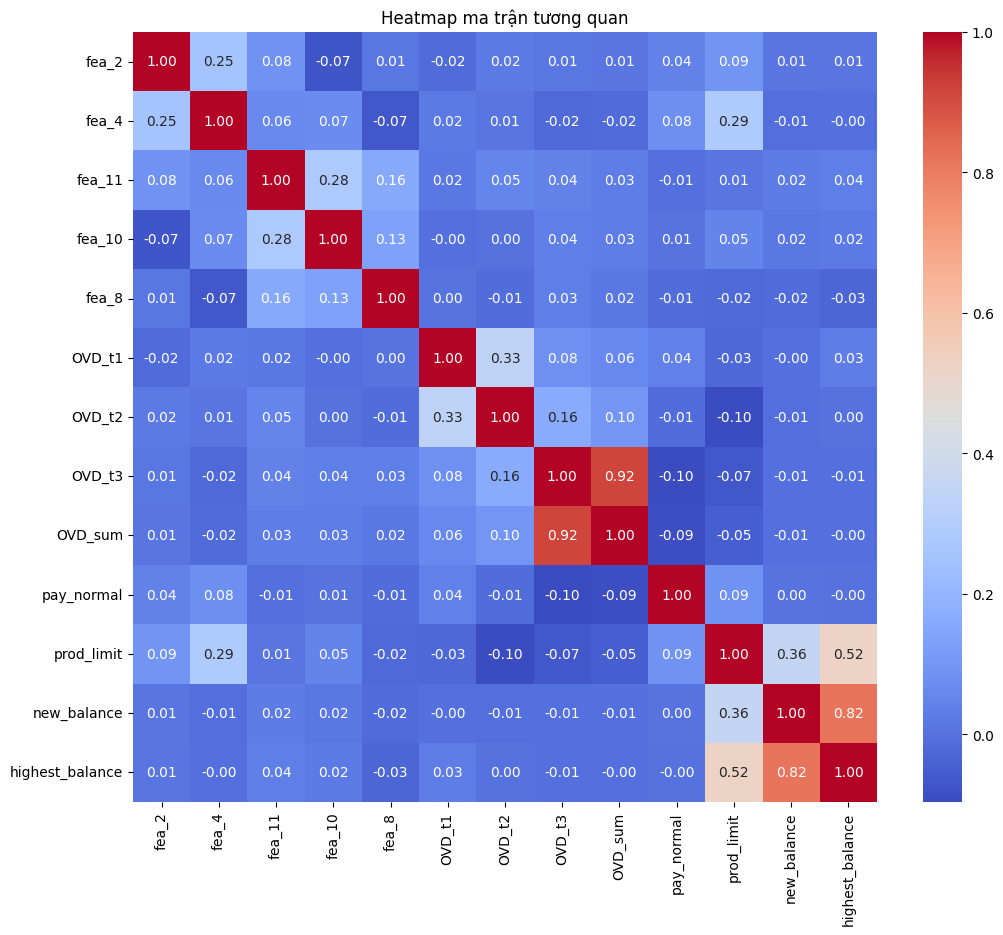

In [62]:
# Xác định các cột số (bao gồm fea_8 và fea_10)
numerical_cols = [
    'fea_2', 'fea_4', 'fea_11', 'fea_10', 'fea_8',
    'OVD_t1', 'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal',
    'prod_limit', 'new_balance', 'highest_balance'
]

# Chọn chỉ các cột số từ DataFrame
df_numerical = train_df[numerical_cols]

# Tính ma trận tương quan
correlation_matrix = df_numerical.corr()

# Vẽ heatmap của ma trận tương quan
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap ma trận tương quan')
plt.show()


### Quyết định xử lý đa cộng tuyến giữa OVD_t3 và OVD_sum

-> Tồn tại đa cộng tuyến cao giữa OVD_t3 và OVD_sum, có khả năng cao 1 trong 2 biến này là thừa. Phương án xử lý khi đa cộng tuyến cao như vậy của tôi sẽ là bỏ 1 trong 2 biến

Quyết định bỏ biến OVD_t3 vì OVD_sum tổng quát hơn:

In [63]:
train_df.drop("OVD_t3",axis=1,inplace=True)
test_df.drop("OVD_t3",axis=1,inplace=True)

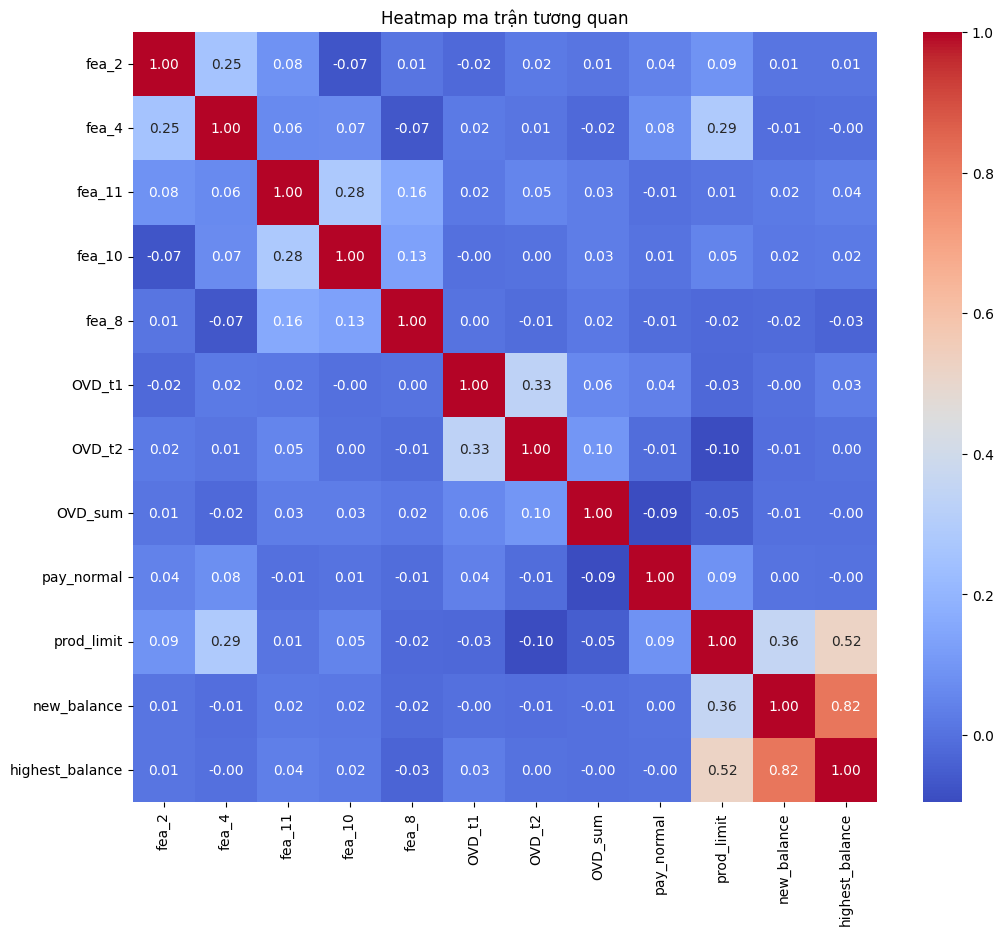

In [64]:
# Xác định các cột số (bao gồm fea_8 và fea_10)
numerical_cols = [
    'fea_2', 'fea_4', 'fea_11', 'fea_10', 'fea_8',
    'OVD_t1', 'OVD_t2',  'OVD_sum', 'pay_normal',
    'prod_limit', 'new_balance', 'highest_balance'
]

# Chọn chỉ các cột số từ DataFrame
df_numerical = train_df[numerical_cols]

# Tính ma trận tương quan
correlation_matrix = df_numerical.corr()

# Vẽ heatmap của ma trận tương quan
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap ma trận tương quan')
plt.show()

### Quyết định giữ lại biến highest_balace

Vì biến highest_balance đôi khi thiếu null (mà new_balance) không thiếu null vậy nên biến highest_balance đôi khi mang lại 1 ý nghĩa gì đó trong quá khứ (mà tôi không phân tích ở đây)

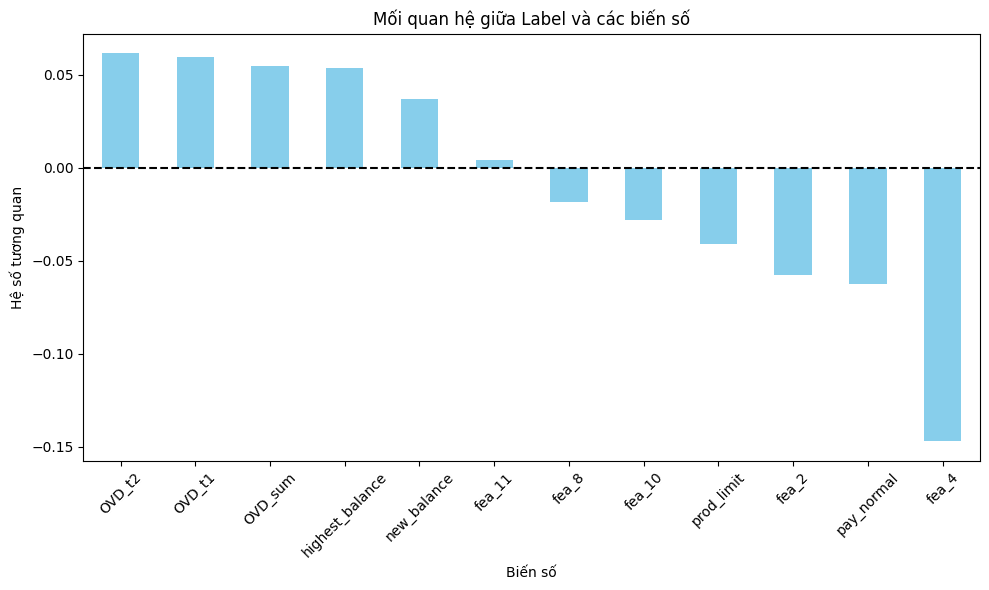

In [65]:
# Xác định các cột số và thêm cột label vào danh sách
numerical_cols_with_label = [
    'label', # Thêm label vào danh sách
    'fea_2', 'fea_4', 'fea_11', 'fea_10', 'fea_8',
    'OVD_t1', 'OVD_t2', 'OVD_sum', 'pay_normal',
    'prod_limit', 'new_balance', 'highest_balance'
]

# Chọn chỉ các cột này từ DataFrame
df_subset = train_df[numerical_cols_with_label]

# Tính ma trận tương quan cho tập con này
correlation_matrix_subset = df_subset.corr()

# Lấy riêng dòng tương quan với label và sắp xếp
label_correlations = correlation_matrix_subset['label'].sort_values(ascending=False)

# Loại bỏ chính label khỏi kết quả
label_correlations = label_correlations.drop('label')

# Vẽ biểu đồ cột cho các hệ số tương quan
plt.figure(figsize=(10, 6))
label_correlations.plot(kind='bar', color='skyblue')
plt.title('Mối quan hệ giữa Label và các biến số')
plt.xlabel('Biến số')
plt.ylabel('Hệ số tương quan')
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

-> Ít có mối quan hệ tuyến tính, không phù hợp khi sử dụng các mô hình tuyến tính như logistic regression

## Triển khai mô hình baseline: Logistic Regression

1. Chia X,Y

In [66]:
X_train, y_train = train_df.drop('label', axis=1), train_df['label']
X_test, y_test = test_df.drop('label', axis=1), test_df['label']

2. Điền null

In [174]:
# Thay null cột fea_2 bằng median do phân phối dạng chuẩn
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(X_train[['fea_2']])

X_train['fea_2'] = imputer.transform(X_train[['fea_2']])
X_test['fea_2'] = imputer.transform(X_test[['fea_2']])

In [175]:
X_train['prod_limit'] = X_train['prod_limit'].fillna(0)
X_test['prod_limit'] = X_test['prod_limit'].fillna(0)

In [176]:
mode_per_group_train = train_df.groupby(['id', 'prod_code'])['highest_balance'].apply(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
mode_per_group_train = mode_per_group_train.rename('highest_balance_mode_by_group').reset_index()

# Merge mode này trở lại train_df
train_df_merged = pd.merge(train_df, mode_per_group_train, on=['id', 'prod_code'], how='left')
# Điền NaN trong 'highest_balance' bằng 'highest_balance_mode_by_group'
train_df['highest_balance'] = train_df['highest_balance'].fillna(train_df_merged['highest_balance_mode_by_group'])

# Sử dụng mode_per_group_train đã tính từ tập train để điền cho test_df
test_df_merged = pd.merge(test_df, mode_per_group_train, on=['id', 'prod_code'], how='left')
test_df['highest_balance'] = test_df['highest_balance'].fillna(test_df_merged['highest_balance_mode_by_group'])

# Option 1: Điền bằng mode toàn cục của cột 'highest_balance' từ tập train
global_mode_highest_balance_train = train_df['highest_balance'].mode() # Có thể vẫn còn NaN từ bước trước
# Cần đảm bảo global_mode_highest_balance_train không rỗng và không chứa NaN
# Nếu cột highest_balance sau khi fill theo group vẫn còn nhiều NaN, tính mode trên cột đã được fill một phần đó.
if not train_df['highest_balance'].mode().empty:
    fill_value_global = train_df['highest_balance'].mode()[0]
    train_df['highest_balance'].fillna(fill_value_global, inplace=True)
    test_df['highest_balance'].fillna(fill_value_global, inplace=True) # Dùng giá trị từ train
else:
    # Nếu ngay cả mode toàn cục cũng không có (rất hiếm nếu cột có dữ liệu)
    # Có thể fill bằng median hoặc một hằng số (ví dụ 0)
    fill_value_fallback = train_df['highest_balance'].median() # Hoặc 0
    train_df['highest_balance'].fillna(fill_value_fallback, inplace=True)
    test_df['highest_balance'].fillna(fill_value_fallback, inplace=True)

In [177]:
date_component_cols_to_impute = [
    'report_year', 'report_month', 'report_day',
    'update_year', 'update_month', 'update_day'
]
knn_imputer = KNNImputer(n_neighbors=5)
numerical_features_for_knn = X_train.select_dtypes(include=np.number).columns.tolist()
print(f"Các cột số sẽ được sử dụng để fit KNNImputer: {numerical_features_for_knn}")

# Transform (điền null) cho các cột số trong X_train và X_test
# Kết quả trả về là một NumPy array, cần chuyển lại thành DataFram
knn_imputer.fit(X_train[numerical_features_for_knn])
X_train_knn_imputed_values = knn_imputer.transform(X_train[numerical_features_for_knn])
X_test_knn_imputed_values = knn_imputer.transform(X_test[numerical_features_for_knn])

# Gán lại giá trị đã điền null vào X_train và X_test
# Đảm bảo giữ nguyên tên cột và index
X_train[numerical_features_for_knn] = pd.DataFrame(X_train_knn_imputed_values, columns=numerical_features_for_knn, index=X_train.index)
X_test[numerical_features_for_knn] = pd.DataFrame(X_test_knn_imputed_values, columns=numerical_features_for_knn, index=X_test.index)



Các cột số sẽ được sử dụng để fit KNNImputer: ['id', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6', 'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11', 'OVD_t1', 'OVD_t2', 'OVD_sum', 'pay_normal', 'prod_code', 'prod_limit', 'new_balance', 'highest_balance', 'prod_limit_is_missing', 'report_date_is_missing', 'report_year', 'report_month', 'report_day', 'update_year', 'update_month', 'update_day']


3. Xóa các cột thừa

In [178]:
X_train.drop(["id","prod_code"],axis=1,inplace=True)
X_test.drop(["id","prod_code"],axis=1,inplace=True)

4. Mã hóa các cột category và chuẩn hóa các cột số

In [179]:

numerical_cols = [
    'fea_2', 'fea_4', 'fea_11', 'fea_8', 'fea_10',
    'OVD_t1', 'OVD_t2', 'OVD_sum', 'pay_normal',
    'prod_limit', 'new_balance'
]

categorical_cols = [
    'fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9'
]

# Xác định các cột số có vẻ bị lệch nặng để áp dụng biến đổi Yeo-Johnson
skewed_cols = [
    'fea_4', 'fea_10',
    'OVD_t1', 'OVD_t2', 'OVD_sum', 'pay_normal',
    'prod_limit', 'new_balance', 'highest_balance'
]

# Các cột số còn lại không áp dụng biến đổi Yeo-Johnson
non_skewed_cols = [col for col in numerical_cols if col not in skewed_cols]

# Áp dụng biến đổi Yeo-Johnson cho các cột bị lệch trong X_train và X_test
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')

# Fit CHỈ trên X_train và transform cả X_train và X_test
X_train[skewed_cols] = yeo_johnson_transformer.fit_transform(X_train[skewed_cols])
X_test[skewed_cols] = yeo_johnson_transformer.transform(X_test[skewed_cols])

# Áp dụng StandardScaler cho TẤT CẢ các cột số trong X_train và X_test
scaler = StandardScaler()

# Fit CHỈ trên X_train và transform cả X_train và X_test
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- Xử lý cột phân loại (One-Hot Encoding) ---

# Khởi tạo OneHotEncoder
# handle_unknown='ignore' để xử lý các danh mục mới trong tập test nếu có
# sparse_output=False để kết quả là dense array, dễ làm việc với DataFrame
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit CHỈ trên X_train và transform cả X_train và X_test
X_train_cat_encoded = ohe.fit_transform(X_train[categorical_cols])
X_test_cat_encoded = ohe.transform(X_test[categorical_cols])

# Tạo DataFrame từ kết quả One-Hot Encoding
# Lấy tên cột mới sau OHE
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, index=X_train.index, columns=ohe_feature_names)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, index=X_test.index, columns=ohe_feature_names)

# Bỏ các cột phân loại gốc khỏi X_train và X_test
X_train = X_train.drop(columns=categorical_cols)
X_test = X_test.drop(columns=categorical_cols)

# Kết hợp các cột số đã xử lý và các cột phân loại đã mã hóa
X_train_processed = pd.concat([X_train, X_train_cat_df], axis=1)
X_test_processed = pd.concat([X_test, X_test_cat_df], axis=1)

5. Train model

In [180]:
# Giả sử X_train_processed và X_test_processed là dữ liệu đã qua các bước trên
model_baseline = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
# class_weight='balanced' nếu dữ liệu mất cân bằng
model_baseline.fit(X_train_processed, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [181]:
# Dự đoán trên tập Train
y_pred_train_baseline = model_baseline.predict(X_train_processed)
y_pred_proba_train_baseline = model_baseline.predict_proba(X_train_processed)[:, 1] # Xác suất của lớp 1 cho tập train

# Dự đoán trên tập Test (bạn đã làm ở bước trước)
y_pred_test_baseline = model_baseline.predict(X_test_processed) # Hoặc y_pred_baseline từ bước trước
y_pred_proba_test_baseline = model_baseline.predict_proba(X_test_processed)[:, 1] # Hoặc y_pred_proba_baseline từ bước trước

6. So sánh hiệu suất

In [182]:
# --- Đánh giá trên tập TRAIN ---
print("="*30 + " KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) " + "="*30)
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train_baseline))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_baseline))

accuracy_train = accuracy_score(y_train, y_pred_train_baseline)
precision_train = precision_score(y_train, y_pred_train_baseline, zero_division=0) # zero_division=0 để tránh lỗi nếu không có TP+FP
recall_train = recall_score(y_train, y_pred_train_baseline, zero_division=0)
f1_train = f1_score(y_train, y_pred_train_baseline, zero_division=0)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train_baseline)

print(f"\nAccuracy (Train): {accuracy_train:.4f}")
print(f"Precision (Train - cho lớp 1): {precision_train:.4f}")
print(f"Recall (Train - cho lớp 1): {recall_train:.4f}")
print(f"F1-score (Train - cho lớp 1): {f1_train:.4f}")
print(f"ROC AUC (Train): {roc_auc_train:.4f}")
print("\n" + "="*80 + "\n")


# --- Đánh giá trên tập TEST ---
print("="*30 + " KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) " + "="*30)
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_baseline))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_baseline))

accuracy_test = accuracy_score(y_test, y_pred_test_baseline)
precision_test = precision_score(y_test, y_pred_test_baseline, zero_division=0)
recall_test = recall_score(y_test, y_pred_test_baseline, zero_division=0)
f1_test = f1_score(y_test, y_pred_test_baseline, zero_division=0)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test_baseline)

print(f"\nAccuracy (Test): {accuracy_test:.4f}")
print(f"Precision (Test - cho lớp 1): {precision_test:.4f}")
print(f"Recall (Test - cho lớp 1): {recall_test:.4f}")
print(f"F1-score (Test - cho lớp 1): {f1_test:.4f}")
print(f"ROC AUC (Test): {roc_auc_test:.4f}")
print("\n" + "="*80 + "\n")

# --- So sánh trực tiếp ---
print("="*30 + " SO SÁNH TRAIN vs TEST " + "="*30)
print(f"{'Metric':<15} | {'Train':<10} | {'Test':<10} | {'Difference (Train-Test)':<25}")
print("-"*70)
print(f"{'Accuracy':<15} | {accuracy_train:<10.4f} | {accuracy_test:<10.4f} | {accuracy_train - accuracy_test:<25.4f}")
print(f"{'Precision (1)':<15} | {precision_train:<10.4f} | {precision_test:<10.4f} | {precision_train - precision_test:<25.4f}")
print(f"{'Recall (1)':<15} | {recall_train:<10.4f} | {recall_test:<10.4f} | {recall_train - recall_test:<25.4f}")
print(f"{'F1-score (1)':<15} | {f1_train:<10.4f} | {f1_test:<10.4f} | {f1_train - f1_test:<25.4f}")
print(f"{'ROC AUC':<15} | {roc_auc_train:<10.4f} | {roc_auc_test:<10.4f} | {roc_auc_train - roc_auc_test:<25.4f}")

============================== KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) ==============================
Confusion Matrix (Train):
[[3596 1831]
 [ 362  738]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.91      0.66      0.77      5427
           1       0.29      0.67      0.40      1100

    accuracy                           0.66      6527
   macro avg       0.60      0.67      0.58      6527
weighted avg       0.80      0.66      0.70      6527


Accuracy (Train): 0.6640
Precision (Train - cho lớp 1): 0.2873
Recall (Train - cho lớp 1): 0.6709
F1-score (Train - cho lớp 1): 0.4023
ROC AUC (Train): 0.7314


============================== KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) ==============================
Confusion Matrix (Test):
[[916 441]
 [ 90 185]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1357
           1       0.30      0.67      0.41  

## Triển khai mô hình thứ 2: RandomForest

In [183]:
# Khởi tạo mô hình Random Forest (có thể dùng cùng tham số như Cách 1 để so sánh công bằng)
class_weight_input = 'balanced_subsample' if y_train.value_counts(normalize=True)[1] < 0.4 else None
rf_model_v2 = RandomForestClassifier(random_state=42, 
                                     n_estimators=100, 
                                     class_weight= class_weight_input)

# Huấn luyện mô hình
rf_model_v2.fit(X_train_processed, y_train) # Sử dụng X_train_c2 đã qua xử lý kỹ lưỡng

# Dự đoán trên tập Train và Test
y_pred_train_v2 = rf_model_v2.predict(X_train_processed)
y_pred_proba_train_v2 = rf_model_v2.predict_proba(X_train_processed)[:, 1]

y_pred_test_v2 = rf_model_v2.predict(X_test_processed)
y_pred_proba_test_v2 = rf_model_v2.predict_proba(X_test_processed)[:, 1]

In [184]:
# --- Đánh giá trên tập TRAIN ---
print("="*30 + " KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) " + "="*30)
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train_v2))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_v2))

accuracy_train = accuracy_score(y_train, y_pred_train_v2)
precision_train = precision_score(y_train, y_pred_train_v2, zero_division=0) # zero_division=0 để tránh lỗi nếu không có TP+FP
recall_train = recall_score(y_train, y_pred_train_v2, zero_division=0)
f1_train = f1_score(y_train, y_pred_train_v2, zero_division=0)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train_v2)

print(f"\nAccuracy (Train): {accuracy_train:.4f}")
print(f"Precision (Train - cho lớp 1): {precision_train:.4f}")
print(f"Recall (Train - cho lớp 1): {recall_train:.4f}")
print(f"F1-score (Train - cho lớp 1): {f1_train:.4f}")
print(f"ROC AUC (Train): {roc_auc_train:.4f}")
print("\n" + "="*80 + "\n")


# --- Đánh giá trên tập TEST ---
print("="*30 + " KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) " + "="*30)
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_v2))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_v2))

accuracy_test = accuracy_score(y_test, y_pred_test_v2)
precision_test = precision_score(y_test, y_pred_test_v2, zero_division=0)
recall_test = recall_score(y_test, y_pred_test_v2, zero_division=0)
f1_test = f1_score(y_test, y_pred_test_v2, zero_division=0)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test_v2)

print(f"\nAccuracy (Test): {accuracy_test:.4f}")
print(f"Precision (Test - cho lớp 1): {precision_test:.4f}")
print(f"Recall (Test - cho lớp 1): {recall_test:.4f}")
print(f"F1-score (Test - cho lớp 1): {f1_test:.4f}")
print(f"ROC AUC (Test): {roc_auc_test:.4f}")
print("\n" + "="*80 + "\n")

# --- So sánh trực tiếp ---
print("="*30 + " SO SÁNH TRAIN vs TEST " + "="*30)
print(f"{'Metric':<15} | {'Train':<10} | {'Test':<10} | {'Difference (Train-Test)':<25}")
print("-"*70)
print(f"{'Accuracy':<15} | {accuracy_train:<10.4f} | {accuracy_test:<10.4f} | {accuracy_train - accuracy_test:<25.4f}")
print(f"{'Precision (1)':<15} | {precision_train:<10.4f} | {precision_test:<10.4f} | {precision_train - precision_test:<25.4f}")
print(f"{'Recall (1)':<15} | {recall_train:<10.4f} | {recall_test:<10.4f} | {recall_train - recall_test:<25.4f}")
print(f"{'F1-score (1)':<15} | {f1_train:<10.4f} | {f1_test:<10.4f} | {f1_train - f1_test:<25.4f}")
print(f"{'ROC AUC':<15} | {roc_auc_train:<10.4f} | {roc_auc_test:<10.4f} | {roc_auc_train - roc_auc_test:<25.4f}")


============================== KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) ==============================
Confusion Matrix (Train):
[[5427    0]
 [   0 1100]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5427
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      6527
   macro avg       1.00      1.00      1.00      6527
weighted avg       1.00      1.00      1.00      6527


Accuracy (Train): 1.0000
Precision (Train - cho lớp 1): 1.0000
Recall (Train - cho lớp 1): 1.0000
F1-score (Train - cho lớp 1): 1.0000
ROC AUC (Train): 1.0000


============================== KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) ==============================
Confusion Matrix (Test):
[[1357    0]
 [ 135  140]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      1357
           1       1.00      0.51      0.

-> Mặc dù con số trên tập test là khá ấn tượng, xong ta thấy hiện tượng overfitting nặng

#### Phương án xử lý: tìm bộ siêu tham số giúp cân bằng giữa train và test bằng cách áp dụng RandomizedSearchCV

In [185]:
from scipy.stats import randint
# Định nghĩa không gian siêu tham số để tìm kiếm
param_distributions = {
    'n_estimators': randint(100, 500),  # Số cây từ 100 đến 499
    'max_depth': [5, 8, 10, 15, 20, 25, 30, None], # Vẫn có thể dùng danh sách cho một số tham số
    'min_samples_split': randint(2, 21), # Số mẫu tối thiểu để chia từ 2 đến 20
    'min_samples_leaf': randint(1, 21),  # Số mẫu tối thiểu ở lá từ 1 đến 20
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7], # Có thể dùng danh sách hoặc phân phối
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'bootstrap': [True, False] 
}



rf_clf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf_clf,
                                   param_distributions=param_distributions,
                                   n_iter=50,  
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='roc_auc') 

In [186]:
# Fit RandomizedSearchCV trên dữ liệu huấn luyện
print("Bắt đầu RandomizedSearchCV...")
random_search.fit(X_train_processed, y_train)
print("RandomizedSearchCV hoàn thành.")

Bắt đầu RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
RandomizedSearchCV hoàn thành.


In [187]:
# In ra các siêu tham số tốt nhất
print("\nSiêu tham số tốt hơn tìm được từ RandomizedSearchCV:")
print(random_search.best_params_)

# Lấy mô hình tốt nhất
best_rf_model_random = random_search.best_estimator_


Siêu tham số tốt hơn tìm được từ RandomizedSearchCV:
{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 30, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 225}


In [188]:
# Đánh giá mô hình tốt nhất trên tập train và test
y_pred_train_best_random = best_rf_model_random.predict(X_train_processed)
y_pred_proba_train_best_random = best_rf_model_random.predict_proba(X_train_processed)[:, 1]

y_pred_test_best_random = best_rf_model_random.predict(X_test_processed)
y_pred_proba_test_best_random = best_rf_model_random.predict_proba(X_test_processed)[:, 1]

In [189]:

# --- Đánh giá trên tập TRAIN ---
print("="*30 + " KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) " + "="*30)
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train_best_random))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_best_random))

accuracy_train = accuracy_score(y_train, y_pred_train_best_random)
precision_train = precision_score(y_train, y_pred_train_best_random, zero_division=0) # zero_division=0 để tránh lỗi nếu không có TP+FP
recall_train = recall_score(y_train, y_pred_train_best_random, zero_division=0)
f1_train = f1_score(y_train, y_pred_train_best_random, zero_division=0)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train_best_random)

print(f"\nAccuracy (Train): {accuracy_train:.4f}")
print(f"Precision (Train - cho lớp 1): {precision_train:.4f}")
print(f"Recall (Train - cho lớp 1): {recall_train:.4f}")
print(f"F1-score (Train - cho lớp 1): {f1_train:.4f}")
print(f"ROC AUC (Train): {roc_auc_train:.4f}")
print("\n" + "="*80 + "\n")


# --- Đánh giá trên tập TEST ---
print("="*30 + " KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) " + "="*30)
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_best_random))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_best_random))

accuracy_test = accuracy_score(y_test, y_pred_test_best_random)
precision_test = precision_score(y_test, y_pred_test_best_random, zero_division=0)
recall_test = recall_score(y_test, y_pred_test_best_random, zero_division=0)
f1_test = f1_score(y_test, y_pred_test_best_random, zero_division=0)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test_best_random)

print(f"\nAccuracy (Test): {accuracy_test:.4f}")
print(f"Precision (Test - cho lớp 1): {precision_test:.4f}")
print(f"Recall (Test - cho lớp 1): {recall_test:.4f}")
print(f"F1-score (Test - cho lớp 1): {f1_test:.4f}")
print(f"ROC AUC (Test): {roc_auc_test:.4f}")
print("\n" + "="*80 + "\n")

# --- So sánh trực tiếp ---
print("="*30 + " SO SÁNH TRAIN vs TEST " + "="*30)
print(f"{'Metric':<15} | {'Train':<10} | {'Test':<10} | {'Difference (Train-Test)':<25}")
print("-"*70)
print(f"{'Accuracy':<15} | {accuracy_train:<10.4f} | {accuracy_test:<10.4f} | {accuracy_train - accuracy_test:<25.4f}")
print(f"{'Precision (1)':<15} | {precision_train:<10.4f} | {precision_test:<10.4f} | {precision_train - precision_test:<25.4f}")
print(f"{'Recall (1)':<15} | {recall_train:<10.4f} | {recall_test:<10.4f} | {recall_train - recall_test:<25.4f}")
print(f"{'F1-score (1)':<15} | {f1_train:<10.4f} | {f1_test:<10.4f} | {f1_train - f1_test:<25.4f}")
print(f"{'ROC AUC':<15} | {roc_auc_train:<10.4f} | {roc_auc_test:<10.4f} | {roc_auc_train - roc_auc_test:<25.4f}")


============================== KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) ==============================
Confusion Matrix (Train):
[[5427    0]
 [   0 1100]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5427
           1       1.00      1.00      1.00      1100

    accuracy                           1.00      6527
   macro avg       1.00      1.00      1.00      6527
weighted avg       1.00      1.00      1.00      6527


Accuracy (Train): 1.0000
Precision (Train - cho lớp 1): 1.0000
Recall (Train - cho lớp 1): 1.0000
F1-score (Train - cho lớp 1): 1.0000
ROC AUC (Train): 1.0000


============================== KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) ==============================
Confusion Matrix (Test):
[[1353    4]
 [  11  264]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1357
           1       0.99      0.96      0.

Top 20 Feature Importances từ Random Forest:
fea_4              0.233514
fea_10             0.150166
fea_2              0.128155
fea_11             0.116756
fea_8              0.101670
fea_6_11.0         0.023412
fea_9_5.0          0.013797
fea_9_3.0          0.013448
fea_7_5.0          0.012959
fea_3_1.0          0.012612
fea_3_3.0          0.012415
fea_7_9.0          0.011058
fea_7_-1.0         0.010886
fea_1_7.0          0.010484
fea_9_4.0          0.009805
highest_balance    0.008618
update_year        0.008113
fea_5_2.0          0.007796
fea_5_1.0          0.007721
report_day         0.007318
dtype: float64


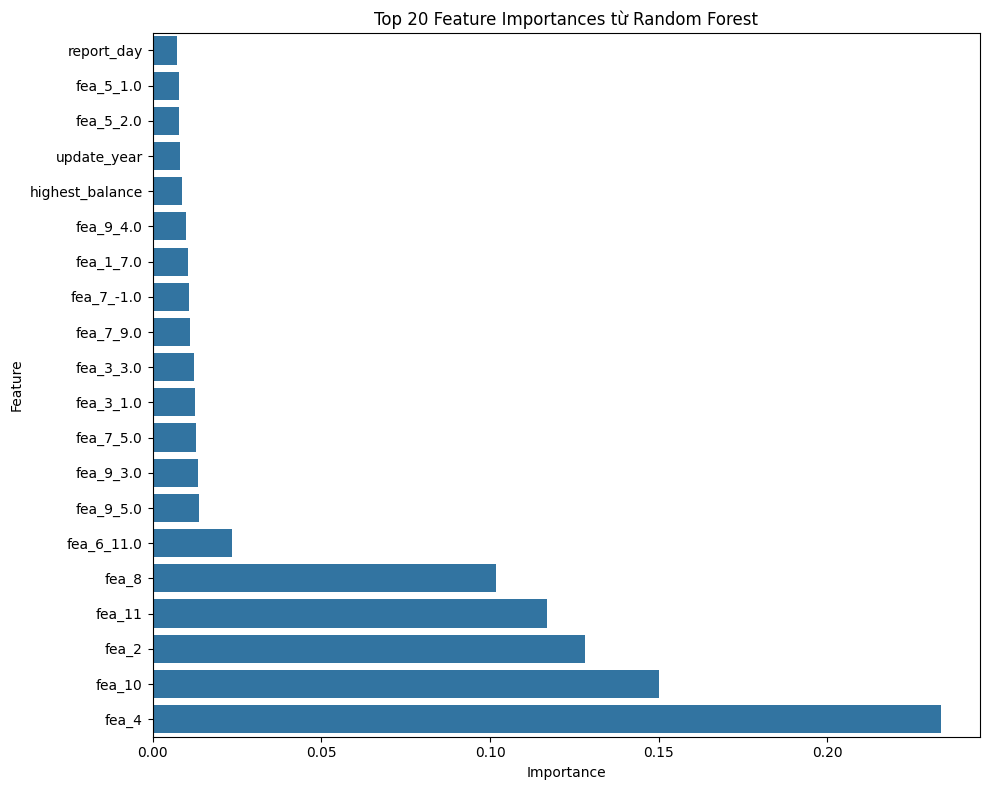

In [190]:

try:
    feature_names = X_train_processed.columns
except AttributeError:
    # Nếu X_train_processed là numpy array, bạn cần có danh sách tên feature từ trước
    # Ví dụ: feature_names = list_of_your_feature_names_in_order
    print("X_train_processed không phải là DataFrame. Hãy đảm bảo bạn có danh sách feature_names chính xác.")
    # Dừng lại hoặc cung cấp feature_names thủ công
    # feature_names = [...] # Điền tên feature của bạn vào đây theo đúng thứ tự

# Lấy giá trị feature importances từ mô hình
importances = best_rf_model_random.feature_importances_

# Tạo một Series Pandas để dễ dàng xem và sắp xếp
forest_importances = pd.Series(importances, index=feature_names)

# Sắp xếp các feature theo tầm quan trọng giảm dần
sorted_forest_importances = forest_importances.sort_values(ascending=False)

# In ra các feature quan trọng nhất (ví dụ: top 20)
print("Top 20 Feature Importances từ Random Forest:")
print(sorted_forest_importances.head(20))

# Trực quan hóa Feature Importances (ví dụ: top 20)
plt.figure(figsize=(10, 8)) # Điều chỉnh kích thước nếu cần
top_n = 20
sns.barplot(x=sorted_forest_importances.head(top_n).values, y=sorted_forest_importances.head(top_n).index)
# Hoặc dùng pandas plot:
# sorted_forest_importances.head(top_n).plot(kind='barh')
plt.title(f'Top {top_n} Feature Importances từ Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() # Để feature quan trọng nhất ở trên cùng nếu dùng barh
plt.tight_layout()
plt.show()

## Phương án tiếp theo: Giảm bớt features 

In [191]:
X_train_processed.drop(["fea_4"],axis=1,inplace=True)

In [192]:
X_test_processed.drop(["fea_10", "fea_2"],axis=1,inplace=True)
X_train_processed.drop(["fea_10", "fea_2"],axis=1,inplace=True)

In [193]:
X_test_processed.drop(["fea_8", "fea_11"],axis=1,inplace=True)
X_train_processed.drop(["fea_8", "fea_11"],axis=1,inplace=True)

In [194]:
X_test_processed.drop(["fea_4"],axis=1,inplace=True)

In [195]:
random_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'max_depth': [5, 8, 10, 15, 20, 25, 30,
                                                      None],
                                        'max_features': ['sqrt', 'log2', 0.3,
                                                         0.5, 0.7],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CA08AAC440>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CA08A73500>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CA08ACCDD0>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [196]:
# In ra các siêu tham số tốt nhất
print("\nSiêu tham số tốt nhất tìm được từ RandomizedSearchCV:")
print(random_search.best_params_)

# Lấy mô hình tốt nhất
best_rf_model_random = random_search.best_estimator_



Siêu tham số tốt nhất tìm được từ RandomizedSearchCV:
{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 19, 'n_estimators': 317}


In [197]:
# Đánh giá mô hình tốt nhất trên tập train và test
y_pred_train_best_random = best_rf_model_random.predict(X_train_processed)
y_pred_proba_train_best_random = best_rf_model_random.predict_proba(X_train_processed)[:, 1]

y_pred_test_best_random = best_rf_model_random.predict(X_test_processed)
y_pred_proba_test_best_random = best_rf_model_random.predict_proba(X_test_processed)[:, 1]
# --- Đánh giá trên tập TRAIN ---
print("="*30 + " KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) " + "="*30)
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train_best_random))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_best_random))

accuracy_train = accuracy_score(y_train, y_pred_train_best_random)
precision_train = precision_score(y_train, y_pred_train_best_random, zero_division=0) # zero_division=0 để tránh lỗi nếu không có TP+FP
recall_train = recall_score(y_train, y_pred_train_best_random, zero_division=0)
f1_train = f1_score(y_train, y_pred_train_best_random, zero_division=0)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train_best_random)

print(f"\nAccuracy (Train): {accuracy_train:.4f}")
print(f"Precision (Train - cho lớp 1): {precision_train:.4f}")
print(f"Recall (Train - cho lớp 1): {recall_train:.4f}")
print(f"F1-score (Train - cho lớp 1): {f1_train:.4f}")
print(f"ROC AUC (Train): {roc_auc_train:.4f}")
print("\n" + "="*80 + "\n")


# --- Đánh giá trên tập TEST ---
print("="*30 + " KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) " + "="*30)
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_best_random))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_best_random))

accuracy_test = accuracy_score(y_test, y_pred_test_best_random)
precision_test = precision_score(y_test, y_pred_test_best_random, zero_division=0)
recall_test = recall_score(y_test, y_pred_test_best_random, zero_division=0)
f1_test = f1_score(y_test, y_pred_test_best_random, zero_division=0)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test_best_random)

print(f"\nAccuracy (Test): {accuracy_test:.4f}")
print(f"Precision (Test - cho lớp 1): {precision_test:.4f}")
print(f"Recall (Test - cho lớp 1): {recall_test:.4f}")
print(f"F1-score (Test - cho lớp 1): {f1_test:.4f}")
print(f"ROC AUC (Test): {roc_auc_test:.4f}")
print("\n" + "="*80 + "\n")

# --- So sánh trực tiếp ---
print("="*30 + " SO SÁNH TRAIN vs TEST " + "="*30)
print(f"{'Metric':<15} | {'Train':<10} | {'Test':<10} | {'Difference (Train-Test)':<25}")
print("-"*70)
print(f"{'Accuracy':<15} | {accuracy_train:<10.4f} | {accuracy_test:<10.4f} | {accuracy_train - accuracy_test:<25.4f}")
print(f"{'Precision (1)':<15} | {precision_train:<10.4f} | {precision_test:<10.4f} | {precision_train - precision_test:<25.4f}")
print(f"{'Recall (1)':<15} | {recall_train:<10.4f} | {recall_test:<10.4f} | {recall_train - recall_test:<25.4f}")
print(f"{'F1-score (1)':<15} | {f1_train:<10.4f} | {f1_test:<10.4f} | {f1_train - f1_test:<25.4f}")
print(f"{'ROC AUC':<15} | {roc_auc_train:<10.4f} | {roc_auc_test:<10.4f} | {roc_auc_train - roc_auc_test:<25.4f}")


============================== KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) ==============================
Confusion Matrix (Train):
[[5069  358]
 [   1 1099]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.93      0.97      5427
           1       0.75      1.00      0.86      1100

    accuracy                           0.94      6527
   macro avg       0.88      0.97      0.91      6527
weighted avg       0.96      0.94      0.95      6527


Accuracy (Train): 0.9450
Precision (Train - cho lớp 1): 0.7543
Recall (Train - cho lớp 1): 0.9991
F1-score (Train - cho lớp 1): 0.8596
ROC AUC (Train): 0.9932


============================== KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) ==============================
Confusion Matrix (Test):
[[1170  187]
 [ 147  128]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.86      0.88      1357
           1       0.41      0.47      0.

## Xử lý overfitting

In [203]:
from scipy.stats import randint, uniform
# Không gian siêu tham số mới, tập trung vào việc chống overfitting
param_distributions_regularized = {
    # 1. Giảm độ phức tạp của cây
    'max_depth': randint(8, 16),  # Giới hạn độ sâu tối đa ở mức vừa phải (8-15)
    # 2. Yêu cầu nhiều bằng chứng hơn để chia nhánh và tạo lá
    'min_samples_split': randint(20, 101), # Yêu cầu ít nhất 20-100 mẫu để chia một node.                     
    'min_samples_leaf': randint(10, 51),   # Mỗi lá phải chứa ít nhất 10-50 mẫu.
    # 3. Giữ nguyên các tham số khác để khám phá
    'n_estimators': randint(100, 500),     # Số lượng cây vẫn quan trọng.  
    'max_features': uniform(0.2, 0.6),     # Thử các giá trị tỷ lệ thay vì các chuỗi cố định.                    
    'class_weight': ['balanced', 'balanced_subsample'], # Vẫn cần xử lý mất cân bằng.
    'bootstrap': [True, False]             # Vẫn giữ để khám phá.
}

In [204]:
random_search = RandomizedSearchCV(estimator=rf_clf,
                                   param_distributions=param_distributions_regularized,
                                   n_iter=50,  
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1,
                                   scoring='roc_auc') 

In [205]:
random_search.fit(X_train_processed, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CA06CC5550>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_continuous_froz...CC7B90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CA06CC5580>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CA06CC5610>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001CA06CC5340>},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
# In ra các siêu tham số tốt nhất
print("\nSiêu tham số hơn tìm được từ RandomizedSearchCV:")
print(random_search.best_params_)

# Lấy mô hình tốt nhất
best_rf_model_random = random_search.best_estimator_


Siêu tham số tốt nhất tìm được từ RandomizedSearchCV:
{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 11, 'max_features': np.float64(0.2099526973567137), 'min_samples_leaf': 12, 'min_samples_split': 38, 'n_estimators': 247}


In [207]:
# Đánh giá mô hình tốt nhất trên tập train và test
y_pred_train_best_random = best_rf_model_random.predict(X_train_processed)
y_pred_proba_train_best_random = best_rf_model_random.predict_proba(X_train_processed)[:, 1]

y_pred_test_best_random = best_rf_model_random.predict(X_test_processed)
y_pred_proba_test_best_random = best_rf_model_random.predict_proba(X_test_processed)[:, 1]
# --- Đánh giá trên tập TRAIN ---
print("="*30 + " KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) " + "="*30)
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train_best_random))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_best_random))

accuracy_train = accuracy_score(y_train, y_pred_train_best_random)
precision_train = precision_score(y_train, y_pred_train_best_random, zero_division=0) # zero_division=0 để tránh lỗi nếu không có TP+FP
recall_train = recall_score(y_train, y_pred_train_best_random, zero_division=0)
f1_train = f1_score(y_train, y_pred_train_best_random, zero_division=0)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train_best_random)

print(f"\nAccuracy (Train): {accuracy_train:.4f}")
print(f"Precision (Train - cho lớp 1): {precision_train:.4f}")
print(f"Recall (Train - cho lớp 1): {recall_train:.4f}")
print(f"F1-score (Train - cho lớp 1): {f1_train:.4f}")
print(f"ROC AUC (Train): {roc_auc_train:.4f}")
print("\n" + "="*80 + "\n")


# --- Đánh giá trên tập TEST ---
print("="*30 + " KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) " + "="*30)
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_best_random))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_best_random))

accuracy_test = accuracy_score(y_test, y_pred_test_best_random)
precision_test = precision_score(y_test, y_pred_test_best_random, zero_division=0)
recall_test = recall_score(y_test, y_pred_test_best_random, zero_division=0)
f1_test = f1_score(y_test, y_pred_test_best_random, zero_division=0)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test_best_random)

print(f"\nAccuracy (Test): {accuracy_test:.4f}")
print(f"Precision (Test - cho lớp 1): {precision_test:.4f}")
print(f"Recall (Test - cho lớp 1): {recall_test:.4f}")
print(f"F1-score (Test - cho lớp 1): {f1_test:.4f}")
print(f"ROC AUC (Test): {roc_auc_test:.4f}")
print("\n" + "="*80 + "\n")

# --- So sánh trực tiếp ---
print("="*30 + " SO SÁNH TRAIN vs TEST " + "="*30)
print(f"{'Metric':<15} | {'Train':<10} | {'Test':<10} | {'Difference (Train-Test)':<25}")
print("-"*70)
print(f"{'Accuracy':<15} | {accuracy_train:<10.4f} | {accuracy_test:<10.4f} | {accuracy_train - accuracy_test:<25.4f}")
print(f"{'Precision (1)':<15} | {precision_train:<10.4f} | {precision_test:<10.4f} | {precision_train - precision_test:<25.4f}")
print(f"{'Recall (1)':<15} | {recall_train:<10.4f} | {recall_test:<10.4f} | {recall_train - recall_test:<25.4f}")
print(f"{'F1-score (1)':<15} | {f1_train:<10.4f} | {f1_test:<10.4f} | {f1_train - f1_test:<25.4f}")
print(f"{'ROC AUC':<15} | {roc_auc_train:<10.4f} | {roc_auc_test:<10.4f} | {roc_auc_train - roc_auc_test:<25.4f}")


============================== KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) ==============================
Confusion Matrix (Train):
[[4451  976]
 [ 120  980]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      5427
           1       0.50      0.89      0.64      1100

    accuracy                           0.83      6527
   macro avg       0.74      0.86      0.77      6527
weighted avg       0.89      0.83      0.85      6527


Accuracy (Train): 0.8321
Precision (Train - cho lớp 1): 0.5010
Recall (Train - cho lớp 1): 0.8909
F1-score (Train - cho lớp 1): 0.6414
ROC AUC (Train): 0.9300


============================== KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) ==============================
Confusion Matrix (Test):
[[1039  318]
 [ 112  163]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1357
           1       0.34      0.59      0.

-> Bớt overfitting hơn rồi

## Sử dụng XGBoost

In [208]:
# 1. TÍNH TOÁN TRỌNG SỐ CHO LỚP (SCALE_POS_WEIGHT)
# Đây là cách xử lý mất cân bằng dữ liệu hiệu quả nhất của XGBoost.
# Nó sẽ "phạt" mô hình nặng hơn khi dự đoán sai một mẫu của lớp thiểu số.
count_negative = np.sum(y_train == 0)
count_positive = np.sum(y_train == 1)
scale_pos_weight_value = count_negative / count_positive if count_positive > 0 else 1
print(f"Calculated scale_pos_weight for XGBoost: {scale_pos_weight_value:.2f}")

Calculated scale_pos_weight for XGBoost: 4.93


In [209]:
# 2. ĐỊNH NGHĨA KHÔNG GIAN SIÊU THAM SỐ CHO XGBOOST
# Không gian này bao gồm các tham số quan trọng nhất để kiểm soát hiệu suất và chống overfitting.
param_distributions_xgb = {
    # Tham số về cấu trúc cây (chống overfitting)
    'max_depth': randint(4, 10),             # Giới hạn độ sâu cây (4-9) để tránh quá phức tạp.
    'gamma': uniform(0, 0.5),                # Yêu cầu mức độ giảm loss tối thiểu để chia nhánh.
    'min_child_weight': randint(1, 10),      # Số lượng mẫu tối thiểu trong một lá.

    # Tham số về điều chuẩn (chống overfitting)
    'reg_alpha': uniform(0, 1),              # L1 regularization.
    'reg_lambda': uniform(0.5, 1.5),         # L2 regularization.

    # Tham số về quá trình học
    'learning_rate': uniform(0.01, 0.2),     # Tốc độ học, giá trị nhỏ thường tốt hơn.
    'n_estimators': randint(150, 600),       # Số lượng cây.

    # Tham số về lấy mẫu (tăng tính ngẫu nhiên, chống overfitting)
    'subsample': uniform(0.6, 0.4),          # Tỷ lệ mẫu được lấy để huấn luyện mỗi cây. (0.6 + 0.4 = 1.0)
    'colsample_bytree': uniform(0.6, 0.4),   # Tỷ lệ đặc trưng được lấy để huấn luyện mỗi cây.
    
    # Tham số xử lý mất cân bằng
    'scale_pos_weight': [scale_pos_weight_value, scale_pos_weight_value * 0.8, scale_pos_weight_value * 1.2]
}

In [210]:
# 3. THIẾT LẬP RANDOMIZEDSEARCHCV
# Khởi tạo mô hình XGBoost cơ bản
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,  # Tắt cảnh báo không cần thiết
    eval_metric='logloss'
)

In [216]:
# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp được giữ nguyên trong mỗi fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [217]:
# Thiết lập RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions_xgb,
    n_iter=50,  # Số lần thử kết hợp tham số. Tăng lên nếu có thời gian (ví dụ: 75, 100)
    cv=kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc' # Vẫn tập trung vào khả năng phân biệt
)


In [218]:
print("Bắt đầu RandomizedSearchCV cho XGBoost...")
random_search_xgb.fit(X_train_processed, y_train) # Bỏ comment dòng này để chạy
print("RandomizedSearchCV cho XGBoost hoàn thành.")

Bắt đầu RandomizedSearchCV cho XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV cho XGBoost hoàn thành.


In [ ]:
# 5. ĐÁNH GIÁ KẾT QUẢ
# Lấy mô hình tốt nhất
best_xgb_model = random_search_xgb.best_estimator_
print("\nSiêu tham số tốt cho XGBoost:")
print(random_search_xgb.best_params_)


Siêu tham số tốt nhất cho XGBoost:
{'colsample_bytree': np.float64(0.8264148841976305), 'gamma': np.float64(0.07932322382124551), 'learning_rate': np.float64(0.03403292956112844), 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 196, 'reg_alpha': np.float64(0.040728802318970136), 'reg_lambda': np.float64(1.7831908760165107), 'scale_pos_weight': np.float64(4.933636363636364), 'subsample': np.float64(0.78966953163493)}


In [226]:

y_pred_train_xgb = best_xgb_model.predict(X_train_processed)
y_pred_proba_train_xgb = best_xgb_model.predict_proba(X_train_processed)[:, 1]

# Dự đoán trên tập Test
y_pred_test_xgb = best_xgb_model.predict(X_test_processed)
y_pred_proba_test_xgb = best_xgb_model.predict_proba(X_test_processed)[:, 1]


# 3. ĐÁNH GIÁ CHI TIẾT VÀ SO SÁNH

# --- Đánh giá trên tập TRAIN ---
print("="*30 + " KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) " + "="*30)
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train_xgb))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_xgb))

accuracy_train = accuracy_score(y_train, y_pred_train_xgb)
precision_train = precision_score(y_train, y_pred_train_xgb)
recall_train = recall_score(y_train, y_pred_train_xgb)
f1_train = f1_score(y_train, y_pred_train_xgb)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train_xgb)

print(f"\nAccuracy (Train): {accuracy_train:.4f}")
print(f"Precision (Train - cho lớp 1): {precision_train:.4f}")
print(f"Recall (Train - cho lớp 1): {recall_train:.4f}")
print(f"F1-score (Train - cho lớp 1): {f1_train:.4f}")
print(f"ROC AUC (Train): {roc_auc_train:.4f}")
print("\n" + "="*80 + "\n")


# --- Đánh giá trên tập TEST ---
print("="*30 + " KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) " + "="*30)
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_xgb))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_xgb))

accuracy_test = accuracy_score(y_test, y_pred_test_xgb)
precision_test = precision_score(y_test, y_pred_test_xgb)
recall_test = recall_score(y_test, y_pred_test_xgb)
f1_test = f1_score(y_test, y_pred_test_xgb)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test_xgb)

print(f"\nAccuracy (Test): {accuracy_test:.4f}")
print(f"Precision (Test - cho lớp 1): {precision_test:.4f}")
print(f"Recall (Test - cho lớp 1): {recall_test:.4f}")
print(f"F1-score (Test - cho lớp 1): {f1_test:.4f}")
print(f"ROC AUC (Test): {roc_auc_test:.4f}")
print("\n" + "="*80 + "\n")


# --- So sánh trực tiếp ---
print("="*30 + " SO SÁNH TRAIN vs TEST " + "="*30)
print(f"{'Metric':<15} | {'Train':<10} | {'Test':<10} | {'Difference (Train-Test)':<25}")
print("-"*70)
print(f"{'Accuracy':<15} | {accuracy_train:<10.4f} | {accuracy_test:<10.4f} | {accuracy_train - accuracy_test:<25.4f}")
print(f"{'Precision (1)':<15} | {precision_train:<10.4f} | {precision_test:<10.4f} | {precision_train - precision_test:<25.4f}")
print(f"{'Recall (1)':<15} | {recall_train:<10.4f} | {recall_test:<10.4f} | {recall_train - recall_test:<25.4f}")
print(f"{'F1-score (1)':<15} | {f1_train:<10.4f} | {f1_test:<10.4f} | {f1_train - f1_test:<25.4f}")
print(f"{'ROC AUC':<15} | {roc_auc_train:<10.4f} | {roc_auc_test:<10.4f} | {roc_auc_train - roc_auc_test:<25.4f}")

============================== KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) ==============================
Confusion Matrix (Train):
[[4879  548]
 [  34 1066]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      5427
           1       0.66      0.97      0.79      1100

    accuracy                           0.91      6527
   macro avg       0.83      0.93      0.86      6527
weighted avg       0.94      0.91      0.92      6527


Accuracy (Train): 0.9108
Precision (Train - cho lớp 1): 0.6605
Recall (Train - cho lớp 1): 0.9691
F1-score (Train - cho lớp 1): 0.7856
ROC AUC (Train): 0.9825


============================== KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) ==============================
Confusion Matrix (Test):
[[1126  231]
 [ 139  136]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1357
           1       0.37      0.49      0.

## XGBoost cải thiện overfitting

In [ ]:
# 2. ĐỊNH NGHĨA KHÔNG GIAN SIÊU THAM SỐ MỚI (CHỐNG OVERFITTING)
param_distributions_xgb_regularized = {
    # --- Tham số chính để chống overfitting ---
    'max_depth': randint(3, 7),              # GIẢM: Giới hạn độ sâu cây ở mức thấp (3-6).
    'gamma': uniform(0.1, 0.9),              # TĂNG: Yêu cầu mức độ giảm loss lớn hơn để chia nhánh.
    'reg_alpha': uniform(0.1, 1.9),          # TĂNG: Tăng L1 regularization.
    'reg_lambda': uniform(1.0, 4.0),         # TĂNG: Tăng L2 regularization.
    'learning_rate': uniform(0.01, 0.1),     # GIẢM: Giảm tốc độ học để mô hình học cẩn thận hơn.

    # --- Tham số để thúc đẩy Recall ---
    # Thử các giá trị scale_pos_weight lớn hơn để "phạt" nặng hơn khi bỏ sót lớp 1
    'scale_pos_weight': [scale_pos_weight_value * 1.2, 
                         scale_pos_weight_value * 1.5, 
                         scale_pos_weight_value * 2.0],

    # --- Các tham số khác giữ nguyên để khám phá ---
    'n_estimators': randint(150, 600),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

In [228]:
# 3. THIẾT LẬP LẠI RANDOMIZEDSEARCHCV
# Khởi tạo mô hình XGBoost cơ bản
xgb_clf_regularized = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Sử dụng StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Thiết lập RandomizedSearchCV với không gian tham số mới
random_search_xgb_regularized = RandomizedSearchCV(
    estimator=xgb_clf_regularized,
    param_distributions=param_distributions_xgb_regularized,
    n_iter=75,  # Tăng số lần thử lên một chút để khám phá không gian mới tốt hơn
    cv=kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc' # Vẫn tối ưu hóa khả năng phân biệt tổng thể
)

In [229]:
# 4. HUẤN LUYỆN
# Giả sử X_train_clean và X_test_clean là dữ liệu đã được làm sạch

print("Bắt đầu RandomizedSearchCV cho XGBoost (phiên bản cải tiến)...")
random_search_xgb_regularized.fit(X_train_processed, y_train) # Bỏ comment dòng này để chạy
print("RandomizedSearchCV cho XGBoost (phiên bản cải tiến) hoàn thành.")

Bắt đầu RandomizedSearchCV cho XGBoost (phiên bản cải tiến)...
Fitting 5 folds for each of 75 candidates, totalling 375 fits
RandomizedSearchCV cho XGBoost (phiên bản cải tiến) hoàn thành.


In [104]:
# 5. LẤY RA MÔ HÌNH TỐT NHẤT VÀ IN SIÊU THAM SỐ
# Giả sử random_search_xgb_regularized đã được fit
best_xgb_model_regularized = random_search_xgb_regularized.best_estimator_
print("="*30 + " SIÊU THAM SỐ TỐT NHẤT TÌM ĐƯỢC (CẢI TIẾN) " + "="*30)
print(random_search_xgb_regularized.best_params_)
print("="*95 + "\n")


# 6. THỰC HIỆN DỰ ĐOÁN TRÊN TẬP TRAIN VÀ TEST
# Giả sử X_train_clean và X_test_clean là dữ liệu đã được làm sạch
# Dự đoán trên tập Train
y_pred_train_xgb_reg = best_xgb_model_regularized.predict(X_train_processed)
y_pred_proba_train_xgb_reg = best_xgb_model_regularized.predict_proba(X_train_processed)[:, 1]

# Dự đoán trên tập Test
y_pred_test_xgb_reg = best_xgb_model_regularized.predict(X_test_processed)
y_pred_proba_test_xgb_reg = best_xgb_model_regularized.predict_proba(X_test_processed)[:, 1]


# 7. ĐÁNH GIÁ CHI TIẾT VÀ SO SÁNH

# --- Đánh giá trên tập TRAIN ---
print("="*30 + " KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) " + "="*30)
print("Confusion Matrix (Train):")
print(confusion_matrix(y_train, y_pred_train_xgb_reg))
print("\nClassification Report (Train):")
print(classification_report(y_train, y_pred_train_xgb_reg))

accuracy_train = accuracy_score(y_train, y_pred_train_xgb_reg)
precision_train = precision_score(y_train, y_pred_train_xgb_reg)
recall_train = recall_score(y_train, y_pred_train_xgb_reg)
f1_train = f1_score(y_train, y_pred_train_xgb_reg)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train_xgb_reg)

print(f"\nAccuracy (Train): {accuracy_train:.4f}")
print(f"Precision (Train - cho lớp 1): {precision_train:.4f}")
print(f"Recall (Train - cho lớp 1): {recall_train:.4f}")
print(f"F1-score (Train - cho lớp 1): {f1_train:.4f}")
print(f"ROC AUC (Train): {roc_auc_train:.4f}")
print("\n" + "="*95 + "\n")


# --- Đánh giá trên tập TEST ---
print("="*30 + " KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) " + "="*30)
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test_xgb_reg))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test_xgb_reg))

accuracy_test = accuracy_score(y_test, y_pred_test_xgb_reg)
precision_test = precision_score(y_test, y_pred_test_xgb_reg)
recall_test = recall_score(y_test, y_pred_test_xgb_reg)
f1_test = f1_score(y_test, y_pred_test_xgb_reg)
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test_xgb_reg)

print(f"\nAccuracy (Test): {accuracy_test:.4f}")
print(f"Precision (Test - cho lớp 1): {precision_test:.4f}")
print(f"Recall (Test - cho lớp 1): {recall_test:.4f}")
print(f"F1-score (Test - cho lớp 1): {f1_test:.4f}")
print(f"ROC AUC (Test): {roc_auc_test:.4f}")
print("\n" + "="*95 + "\n")


# --- So sánh trực tiếp ---
print("="*30 + " SO SÁNH TRAIN vs TEST " + "="*30)
print(f"{'Metric':<15} | {'Train':<10} | {'Test':<10} | {'Difference (Train-Test)':<25}")
print("-"*70)
print(f"{'Accuracy':<15} | {accuracy_train:<10.4f} | {accuracy_test:<10.4f} | {accuracy_train - accuracy_test:<25.4f}")
print(f"{'Precision (1)':<15} | {precision_train:<10.4f} | {precision_test:<10.4f} | {precision_train - precision_test:<25.4f}")
print(f"{'Recall (1)':<15} | {recall_train:<10.4f} | {recall_test:<10.4f} | {recall_train - recall_test:<25.4f}")
print(f"{'F1-score (1)':<15} | {f1_train:<10.4f} | {f1_test:<10.4f} | {f1_train - f1_test:<25.4f}")
print(f"{'ROC AUC':<15} | {roc_auc_train:<10.4f} | {roc_auc_test:<10.4f} | {roc_auc_train - roc_auc_test:<25.4f}")

NameError: name 'random_search_xgb_regularized' is not defined

## Feature Engineering đợt 2

In [3]:
customer_df = pd.read_csv('customer_data.csv')
payment_df = pd.read_csv('payment_data.csv') 

In [4]:
df_full = pd.merge(customer_df, payment_df, on='id',how="inner")

In [5]:
df_full.drop_duplicates(inplace=True)

In [6]:

# Assuming df_full is already defined and contains the date columns as strings
# Convert the date columns to datetime
df_full['report_date'] = pd.to_datetime(df_full['report_date'])
df_full['update_date'] = pd.to_datetime(df_full['update_date'])

# Now you can calculate the difference in days
df_full['update_report_gap_days'] = (df_full['update_date'] - df_full['report_date']).dt.days
print("Đã tạo đặc trưng: update_report_gap_days")

Đã tạo đặc trưng: update_report_gap_days


In [7]:
train_df, test_df = train_test_split(df_full, test_size=0.2, random_state=42, stratify=df_full['label'])

In [8]:
X_train, y_train = train_df.drop('label', axis=1), train_df['label']
X_test, y_test = test_df.drop('label', axis=1), test_df['label']

In [9]:
X_train_selected = X_train.drop(['fea_2','fea_4','fea_8','fea_10','fea_11'], axis=1)
X_test_selected = X_test.drop(['fea_2','fea_4','fea_8','fea_10','fea_11'], axis=1)

In [10]:
X_train_selected['balance_to_highest_ratio'] = X_train_selected['new_balance'] / (X_train_selected['highest_balance'] + 1e-6)
X_test_selected['balance_to_highest_ratio'] = X_test_selected['new_balance'] / (X_test_selected['highest_balance'] + 1e-6)
print("Đã tạo đặc trưng: balance_to_highest_ratio")

Đã tạo đặc trưng: balance_to_highest_ratio


In [11]:
total_periods_train = X_train_selected['pay_normal'] + X_train_selected['OVD_t1'] + X_train_selected['OVD_t2']
total_overdue_times_train = X_train_selected['OVD_t1'] + X_train_selected['OVD_t2']
X_train_selected['overdue_ratio'] = total_overdue_times_train / (total_periods_train + 1e-6)

total_periods_test = X_test_selected['pay_normal'] + X_test_selected['OVD_t1'] + X_test_selected['OVD_t2']
total_overdue_times_test = X_test_selected['OVD_t1'] + X_test_selected['OVD_t2']
X_test_selected['overdue_ratio'] = total_overdue_times_test / (total_periods_test + 1e-6)

print("Đã tạo đặc trưng: overdue_ratio")

Đã tạo đặc trưng: overdue_ratio


In [12]:
X_train_selected['good_payment_ratio'] = X_train_selected['pay_normal'] / (total_periods_train + 1e-6)
X_test_selected['good_payment_ratio'] = X_test_selected['pay_normal'] / (total_periods_test + 1e-6)
print("Đã tạo đặc trưng: good_payment_ratio") 

Đã tạo đặc trưng: good_payment_ratio


In [13]:
# Xử lý các giá trị vô hạn (inf) có thể phát sinh nếu mẫu số vẫn bằng 0
# Thay thế inf bằng 0 hoặc một giá trị lớn hợp lý
X_train_selected.replace([np.inf, -np.inf], 0, inplace=True)
X_test_selected.replace([np.inf, -np.inf], 0, inplace=True)

### Cách xử lý có phần khác với những mô hình trên: đầu vào sẽ xóa đi các cột update_date và report_date

In [14]:
X_train_selected.columns

Index(['id', 'fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9', 'OVD_t1',
       'OVD_t2', 'OVD_t3', 'OVD_sum', 'pay_normal', 'prod_code', 'prod_limit',
       'update_date', 'new_balance', 'highest_balance', 'report_date',
       'update_report_gap_days', 'balance_to_highest_ratio', 'overdue_ratio',
       'good_payment_ratio'],
      dtype='object')

In [15]:
X_train_selected.drop(["update_date", "report_date"],axis=1,inplace=True)
X_test_selected.drop(["update_date", "report_date"],axis=1,inplace=True)

In [16]:
X_train_selected.isnull().sum()

id                             0
fea_1                          0
fea_3                          0
fea_5                          0
fea_6                          0
fea_7                          0
fea_9                          0
OVD_t1                         0
OVD_t2                         0
OVD_t3                         0
OVD_sum                        0
pay_normal                     0
prod_code                      0
prod_limit                  4835
new_balance                    0
highest_balance              320
update_report_gap_days       868
balance_to_highest_ratio     320
overdue_ratio                  0
good_payment_ratio             0
dtype: int64

### Xử lý null cột update_report_gap_days, balance_to_highest_ratio

In [17]:
X_train_selected["update_report_gap_days"] = X_train_selected["update_report_gap_days"].fillna(X_train_selected["update_report_gap_days"].median())
X_test_selected["update_report_gap_days"] = X_test_selected["update_report_gap_days"].fillna(X_test_selected["update_report_gap_days"].median())

In [18]:
X_train_selected["balance_to_highest_ratio"] = X_train_selected["balance_to_highest_ratio"].fillna(-1)
X_test_selected["balance_to_highest_ratio"] = X_test_selected["balance_to_highest_ratio"].fillna(-1)

### Điền null cho prod_limit vẫn thế

In [19]:
X_train_selected["prod_limit_is_missing"] = X_train_selected["prod_limit"].isnull().astype(int)
X_test_selected["prod_limit_is_missing"] = X_test_selected["prod_limit"].isnull().astype(int)

In [20]:
X_train_selected["prod_limit"] = X_train_selected["prod_limit"].fillna(0)
X_test_selected["prod_limit"] = X_test_selected["prod_limit"].fillna(0)

### Điền null cho highest_balance bằng mode tương ứng của từng id, prod_code. Nếu id nào không có giá trị mode thì điền bằng mode của id đó. Còn nếu id đó không có mode nữa thì điền bằng mode của tổng thể

In [21]:
# Luôn làm việc trên một bản sao để tránh SettingWithCopyWarning
X_train = X_train_selected.copy()
X_test = X_test_selected.copy()

# --- Bước 1: Tính toán tất cả các giá trị mode chỉ từ tập TRAIN ---

# Mode cấp 1: Theo (id, prod_code)
mode_by_group = X_train.groupby(['id', 'prod_code'])['highest_balance'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
)

# Mode cấp 2: Theo (id)
# Tính trên X_train gốc, không phải trên dữ liệu đã điền một phần
mode_by_id = X_train.groupby('id')['highest_balance'].apply(
    lambda x: x.mode()[0] if not x.mode().empty else np.nan
)

# Mode cấp 3: Toàn cục
# Tính trên X_train gốc
global_mode = X_train['highest_balance'].mode()[0]


# --- Bước 2: Áp dụng các giá trị mode đã tính để điền NaN một cách an toàn ---

# Tạo các cột mode tương ứng trong cả train và test set
# Sử dụng .map() và .join() để tránh lỗi merge và giữ nguyên index
X_train['mode_group'] = X_train.set_index(['id', 'prod_code']).index.map(mode_by_group)
X_test['mode_group'] = X_test.set_index(['id', 'prod_code']).index.map(mode_by_group)

X_train['mode_id'] = X_train['id'].map(mode_by_id)
X_test['mode_id'] = X_test['id'].map(mode_by_id)

# Áp dụng logic điền NaN theo 3 cấp
# fillna chỉ điền vào những chỗ NaN, nên ta có thể gọi tuần tự
X_train['highest_balance'].fillna(X_train['mode_group'], inplace=True)
X_train['highest_balance'].fillna(X_train['mode_id'], inplace=True)
X_train['highest_balance'].fillna(global_mode, inplace=True)

X_test['highest_balance'].fillna(X_test['mode_group'], inplace=True)
X_test['highest_balance'].fillna(X_test['mode_id'], inplace=True)
X_test['highest_balance'].fillna(global_mode, inplace=True)

# Xóa các cột mode tạm thời
X_train.drop(columns=['mode_group', 'mode_id'], inplace=True)
X_test.drop(columns=['mode_group', 'mode_id'], inplace=True)

# Cập nhật lại X_train_selected và X_test_selected
X_train_selected = X_train
X_test_selected = X_test

print("Điền giá trị null cho 'highest_balance' thành công.")
# Kiểm tra lại các giá trị null
print("\nSố lượng null còn lại trong highest_balance ở tập train:", X_train_selected['highest_balance'].isnull().sum())
print("Số lượng null còn lại trong highest_balance ở tập test:", X_test_selected['highest_balance'].isnull().sum())


Điền giá trị null cho 'highest_balance' thành công.

Số lượng null còn lại trong highest_balance ở tập train: 0
Số lượng null còn lại trong highest_balance ở tập test: 0


### Vẫn chuẩn hóa như cũ

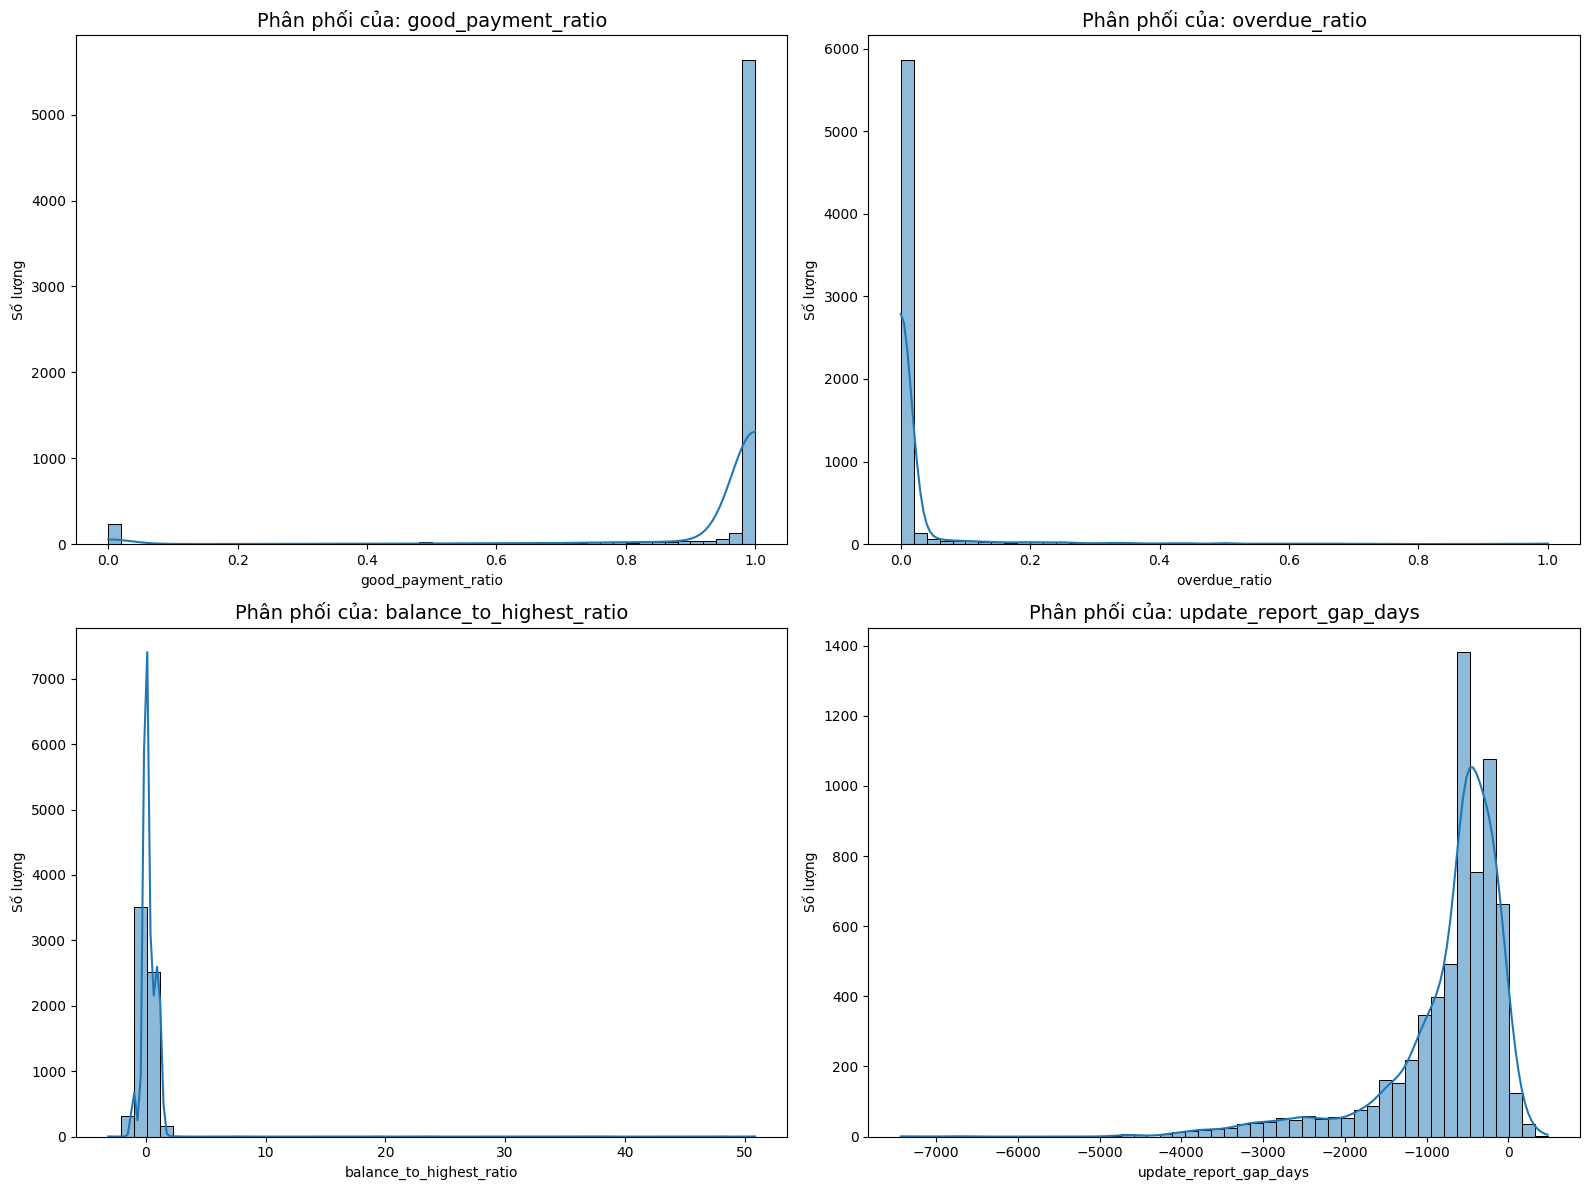

In [24]:

# Các cột cần vẽ
cols_to_plot = [
    'good_payment_ratio', 
    'overdue_ratio', 
    'balance_to_highest_ratio', 
    'update_report_gap_days'
]

# Tạo một figure với 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten() # Làm phẳng mảng axes để dễ dàng lặp

# Vẽ biểu đồ cho từng cột
for i, col in enumerate(cols_to_plot):
    if col in X_train_selected.columns:
        sns.histplot(X_train_selected[col], kde=True, ax=axes[i], bins=50)
        axes[i].set_title(f'Phân phối của: {col}', fontsize=14)
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Số lượng')
    else:
        axes[i].text(0.5, 0.5, f'Cột "{col}" không tồn tại', ha='center', va='center')
        axes[i].set_title(f'Lỗi: {col}', fontsize=14)


plt.tight_layout()
plt.show()


-> Đa phần đều là các phân phối lệch

In [25]:
X_train_selected.drop(columns=["id","prod_code"], inplace=True)
X_test_selected.drop(columns=["id","prod_code"], inplace=True)

In [28]:
X_train_selected.drop(columns=["OVD_t3"], inplace=True)
X_test_selected.drop(columns=["OVD_t3"], inplace=True)

In [29]:
X_train_selected.columns

Index(['fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9', 'OVD_t1',
       'OVD_t2', 'OVD_sum', 'pay_normal', 'prod_limit', 'new_balance',
       'highest_balance', 'update_report_gap_days', 'balance_to_highest_ratio',
       'overdue_ratio', 'good_payment_ratio', 'prod_limit_is_missing'],
      dtype='object')

In [32]:

numerical_cols = [
    'OVD_t1', 'OVD_t2', 'OVD_sum', 'pay_normal', "update_report_gap_days",
    'prod_limit', 'new_balance', 'balance_to_highest_ratio', 'overdue_ratio', 'good_payment_ratio','prod_limit_is_missing'
]

categorical_cols = [
    'fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9'
]

# Xác định các cột số có vẻ bị lệch nặng để áp dụng biến đổi Yeo-Johnson
skewed_cols = [
    'balance_to_highest_ratio', 'overdue_ratio', 'good_payment_ratio','prod_limit_is_missing', "update_report_gap_days",
    'OVD_t1', 'OVD_t2', 'OVD_sum', 'pay_normal',
    'prod_limit', 'new_balance', 'highest_balance'
]

# Các cột số còn lại không áp dụng biến đổi Yeo-Johnson
non_skewed_cols = [col for col in numerical_cols if col not in skewed_cols]

# Áp dụng biến đổi Yeo-Johnson cho các cột bị lệch trong X_train và X_test
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')

# Fit CHỈ trên X_train và transform cả X_train và X_test
X_train_selected[skewed_cols] = yeo_johnson_transformer.fit_transform(X_train_selected[skewed_cols])
X_test_selected[skewed_cols] = yeo_johnson_transformer.transform(X_test_selected[skewed_cols])

# Áp dụng StandardScaler cho TẤT CẢ các cột số trong X_train và X_test
scaler = StandardScaler()

# Fit CHỈ trên X_train và transform cả X_train và X_test
X_train_selected[numerical_cols] = scaler.fit_transform(X_train_selected[numerical_cols])
X_test_selected[numerical_cols] = scaler.transform(X_test_selected[numerical_cols])


# --- Xử lý cột phân loại (One-Hot Encoding) ---

# Khởi tạo OneHotEncoder
# handle_unknown='ignore' để xử lý các danh mục mới trong tập test nếu có
# sparse_output=False để kết quả là dense array, dễ làm việc với DataFrame
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit CHỈ trên X_train và transform cả X_train và X_test
X_train_cat_encoded = ohe.fit_transform(X_train_selected[categorical_cols])
X_test_cat_encoded = ohe.transform(X_test_selected[categorical_cols])

# Tạo DataFrame từ kết quả One-Hot Encoding
# Lấy tên cột mới sau OHE
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)
X_train_cat_df = pd.DataFrame(X_train_cat_encoded, index=X_train_selected.index, columns=ohe_feature_names)
X_test_cat_df = pd.DataFrame(X_test_cat_encoded, index=X_test_selected.index, columns=ohe_feature_names)

# Bỏ các cột phân loại gốc khỏi X_train và X_test
X_train_selected = X_train_selected.drop(columns=categorical_cols)
X_test_selected = X_test_selected.drop(columns=categorical_cols)

# Kết hợp các cột số đã xử lý và các cột phân loại đã mã hóa
X_train_processed = pd.concat([X_train_selected, X_train_cat_df], axis=1)
X_test_processed = pd.concat([X_test_selected, X_test_cat_df], axis=1)

## Train model

In [42]:
# --- 2. Xử lý Mất cân bằng Dữ liệu ---
count_negative = np.sum(y_train == 0)
count_positive = np.sum(y_train == 1)
scale_pos_weight_value = count_negative / count_positive if count_positive > 0 else 1
print(f"Tính toán scale_pos_weight cho XGBoost: {scale_pos_weight_value:.2f}")


# --- 3. Thiết lập RandomizedSearchCV ---
# Định nghĩa không gian siêu tham số để tìm kiếm
param_distributions_xgb_regularized = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.02, 0.05, 0.1], # Tập trung vào tốc độ học thấp
    'max_depth': [3, 4, 5, 6],               # Buộc cây phải nông hơn
    'gamma': [0.5, 1, 1.5, 2, 5],             # Yêu cầu giảm loss nhiều hơn để tạo nhánh
    'subsample': [0.7, 0.8, 0.9],            # Dùng một phần dữ liệu cho mỗi cây
    'colsample_bytree': [0.7, 0.8, 0.9],     # Dùng một phần đặc trưng cho mỗi cây
    'min_child_weight': [3, 5, 7, 10],        # Tăng yêu cầu số mẫu tối thiểu ở lá
    'reg_alpha': [0, 0.1, 0.5, 1],            # Điều tiết L1
    'reg_lambda': [1, 1.5, 2, 5],             # Điều tiết L2
    'scale_pos_weight': [scale_pos_weight_value]
}


# Khởi tạo mô hình XGBoost
xgb_clf = xgb.XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp được giữ nguyên trong mỗi fold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Thiết lập RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_distributions_xgb_regularized,
    n_iter=50,  # Số lần thử kết hợp tham số, bạn có thể tăng nếu có thời gian
    cv=kfold,
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Sử dụng tất cả các CPU
    scoring='roc_auc'
)

Tính toán scale_pos_weight cho XGBoost: 4.93


In [43]:

# --- 4. Huấn luyện và Tinh chỉnh ---
print("\nBắt đầu RandomizedSearchCV cho XGBoost...")
random_search_xgb.fit(X_train_processed, y_train)
print("RandomizedSearchCV cho XGBoost hoàn thành.")



Bắt đầu RandomizedSearchCV cho XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV cho XGBoost hoàn thành.


In [44]:


# --- 5. Đánh giá Mô hình ---
# Lấy ra mô hình và các tham số tốt nhất
best_xgb_model = random_search_xgb.best_estimator_
print("\nSiêu tham số tốt nhất cho XGBoost:")
print(random_search_xgb.best_params_)
print(f"\nBest ROC AUC score from search: {random_search_xgb.best_score_:.4f}")



Siêu tham số tốt nhất cho XGBoost:
{'subsample': 0.9, 'scale_pos_weight': np.float64(4.933636363636364), 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.02, 'gamma': 5, 'colsample_bytree': 0.8}

Best ROC AUC score from search: 0.7212


In [46]:

# Dự đoán trên tập train và test
y_pred_train = best_xgb_model.predict(X_train_processed)
y_pred_proba_train = best_xgb_model.predict_proba(X_train_processed)[:, 1]
y_pred_test = best_xgb_model.predict(X_test_processed)
y_pred_proba_test = best_xgb_model.predict_proba(X_test_processed)[:, 1]

# Hàm in kết quả
def print_evaluation(y_true, y_pred, y_proba, title):
    print("="*30 + f" {title} " + "="*30)
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    roc_auc = roc_auc_score(y_true, y_proba)
    print(f"ROC AUC: {roc_auc:.4f}\n")
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc
    }

# In kết quả
train_metrics = print_evaluation(y_train, y_pred_train, y_pred_proba_train, "KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN)")
test_metrics = print_evaluation(y_test, y_pred_test, y_pred_proba_test, "KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST)")

# So sánh trực tiếp
print("="*30 + " SO SÁNH TRAIN vs TEST " + "="*30)
comparison_df = pd.DataFrame({'Train': train_metrics, 'Test': test_metrics})
comparison_df['Difference (Train-Test)'] = comparison_df['Train'] - comparison_df['Test']
print(comparison_df.round(4))

============================== KẾT QUẢ TRÊN TẬP HUẤN LUYỆN (TRAIN) ==============================
Confusion Matrix:
[[4011 1416]
 [ 239  861]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      5427
           1       0.38      0.78      0.51      1100

    accuracy                           0.75      6527
   macro avg       0.66      0.76      0.67      6527
weighted avg       0.85      0.75      0.78      6527

ROC AUC: 0.8563

============================== KẾT QUẢ TRÊN TẬP KIỂM TRA (TEST) ==============================
Confusion Matrix:
[[939 418]
 [ 87 188]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.69      0.79      1357
           1       0.31      0.68      0.43       275

    accuracy                           0.69      1632
   macro avg       0.61      0.69      0.61      1632
weighted avg       0.81      0.69      0.73      1632

RO